<a href="https://colab.research.google.com/github/rafimagdon-wq/srilankadengueanalysis/blob/main/denguedataanalyticssrilanka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')  # Mount Google Drive

# Use your file path inside Drive
df = pd.read_csv("/content/SriLanka_dengidata_2013_2022.csv", index_col=False)
df.head()


Mounted at /content/drive


Unnamed: 0   index   time        region  meanTair_F_Inst  minTair_F_Inst  \
0           0  7875.0  315.0        Ampara       302.333191      301.926086   
1           1  7876.0  315.0  Anuradhapura       302.066742      301.648224   
2           2  7877.0  315.0       Badulla       296.759888      290.434296   
3           3  7878.0  315.0    Batticaloa       303.107391      302.881073   
4           4  7879.0  315.0       Colombo       300.694458      300.045013   

   maxTair_F_Inst  meanQair_F_Inst  meanSoilmoi0_10Cm_Inst  meanCanopint_Inst  \
0      302.702484         0.017031               25.367788           0.070869   
1      302.776428         0.017640               20.588243           0.000887   
2      302.063751         0.015888               28.335207           0.108685   
3      303.405914         0.017433               20.746124           0.040024   
4      301.343933         0.017812               28.184500           0.110018   

   meanPsurf_F_Inst  meanNdvi   minNdvi   maxNdvi  meanPrecipitationcal  \
0      99238.156250  0.336044  0.181286  0.500243              1.081435   
1      99664.914062  0.329114  0.174629  0.424814              0.031669   
2      91665.226562  0.265771  0.162514  0.409743              1.006210   
3     100180.687500  0.417131  0.307329  0.501071              0.042987   
4      99863.453125  0.333495  0.221043  0.436129              8.888183   

   minPrecipitationcal  maxPrecipitationcal  cases  
0             0.002426             5.917336    3.0  
1             0.000000             0.451204    9.0  
2             0.018600             2.355008   29.0  
3             0.000000             0.689772   23.0  
4             5.248857            14.715760   25.0

Detected columns:
  CSV district: region
  Geo district: shapeName
  Cases: cases | NDVI: meanNdvi | Precip: meanPrecipitationcal | Temp: meanTair_F_Inst

Matched areas: 9 / 10

Pearson correlations with Dengue (province means):
  NDVI vs Dengue          : -0.424
  Precipitation vs Dengue : 0.802
  Temperature vs Dengue   : -0.129


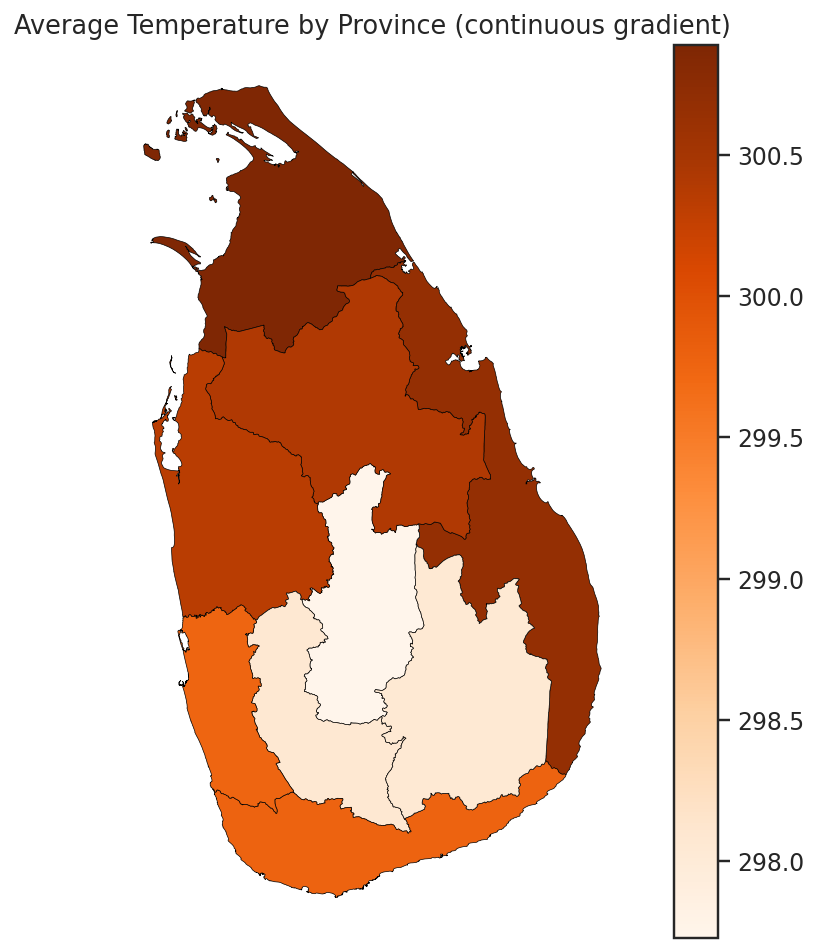

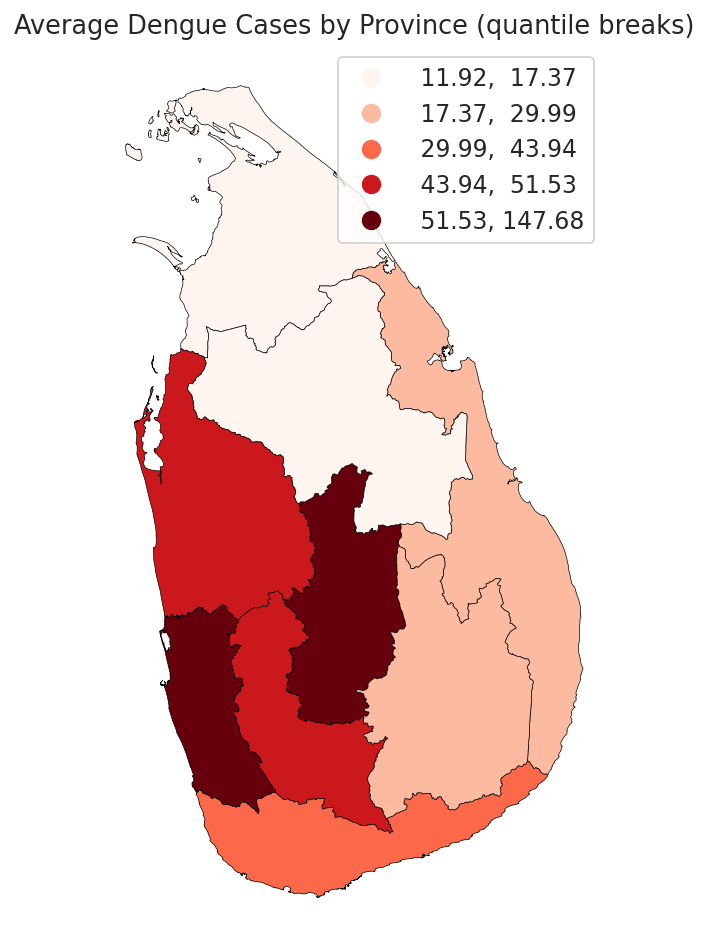


✅ Saved:
 - sri_lanka_temperature_continuous_map.png
 - sri_lanka_dengue_quantile_map.png

(If a map still looks flat, check the printed 'Matched areas' count and ensure temp/cases vary.)


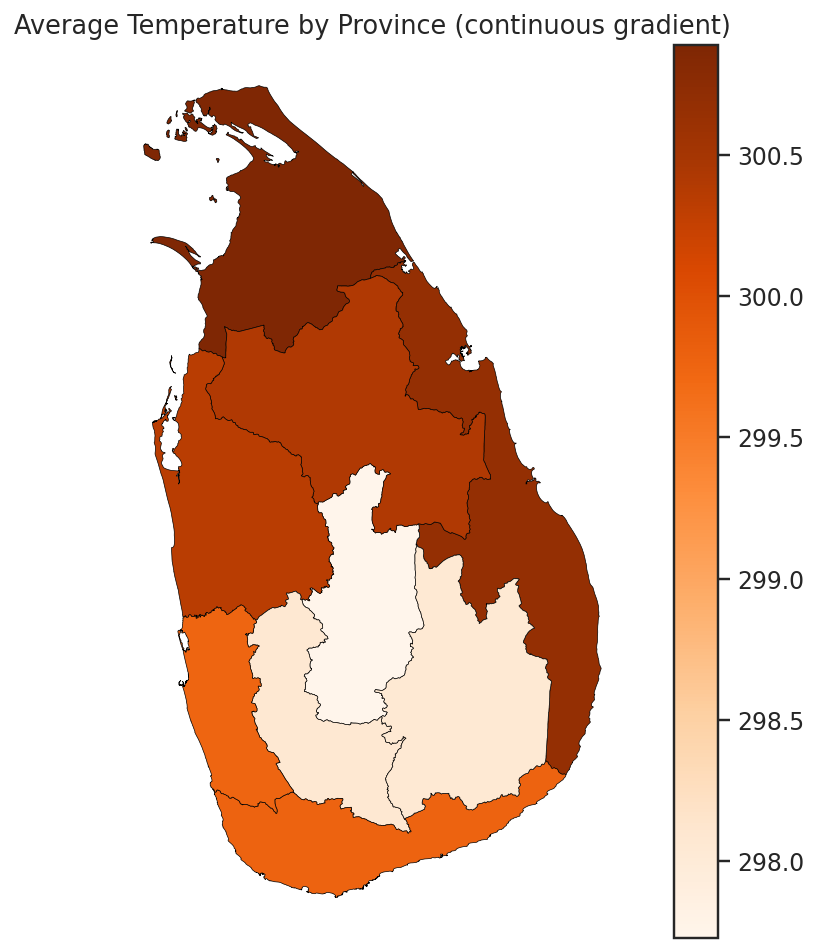

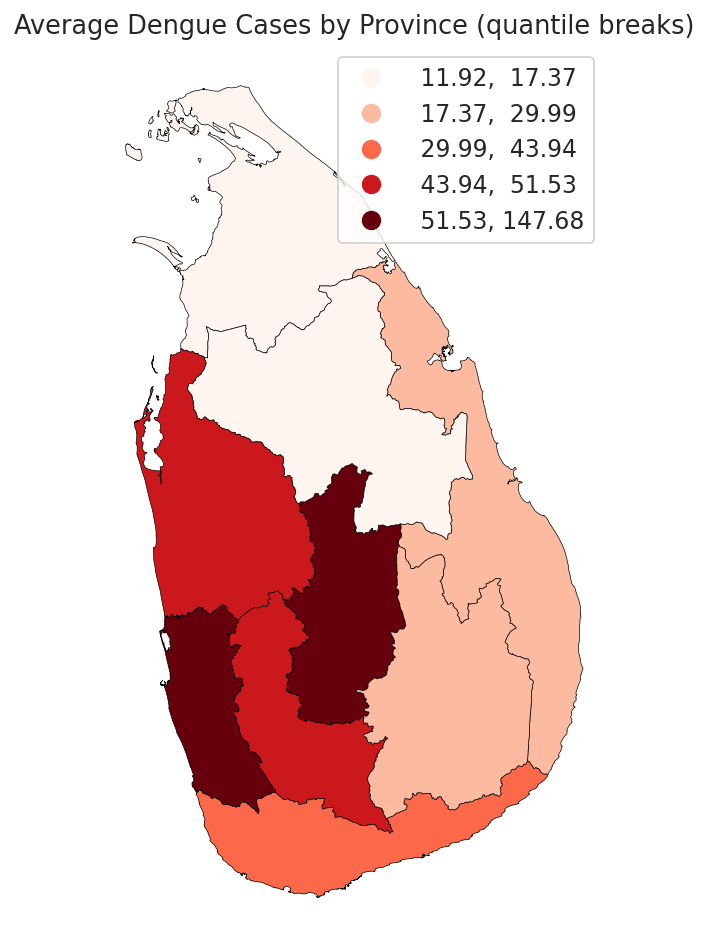

In [41]:
# ================================================================
# Sri Lanka — Temperature Map (continuous colors) + Dengue map
# and Pearson correlations with Dengue (NDVI, Precip, Temp)
# Colab-ready, robust join, clear legends
# ================================================================

# 0) Install deps (Colab)
!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify

# 1) Imports
import pandas as pd, numpy as np, geopandas as gpd, difflib, re
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

# 2) Paths — EDIT if your files are elsewhere
csv_path     = "/content/SriLanka_dengidata_2013_2022.csv"
geojson_path = "/content/sri_lanka_adm1.geojson"

# 3) Load the datasets
df  = pd.read_csv(csv_path)
df  = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

gdf = gpd.read_file(geojson_path)
gdf.columns = [c.strip() for c in gdf.columns]

# 4) Detect key columns (override here if needed)
district_xl = next((c for c in df.columns if any(k in c.lower() for k in ["district","region","name"])), None)
if district_xl is None:
    txt = df.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    if not txt: raise ValueError("No district/region label column found in CSV.")
    district_xl = txt[0]

cases_col = next((c for c in df.columns if c.lower()=="cases"), None) \
        or next((c for c in df.columns if "case" in c.lower()), None)
if cases_col is None: raise ValueError("Couldn't find a 'cases' column.")

ndvi_col = next((c for c in df.columns if "ndvi" in c.lower()), None)
if ndvi_col is None: raise ValueError("Couldn't find an NDVI column.")

precip_col = next((c for c in df.columns if any(k in c.lower() for k in ["precip","prcp","rain","rainfall","ppt"])), None)
if precip_col is None: raise ValueError("Couldn't find a precipitation column.")

temp_col = next((c for c in df.columns if any(k in c.lower() for k in ["temp","temperature","tmean","tmax","tmin","tair"])), None)
if temp_col is None: raise ValueError("Couldn't find a temperature column.")

# District label in GeoJSON
district_geo = next((c for c in ["shapeName","NAME_1","NAME_EN","NAME_2","name","District","DISTRICT"] if c in gdf.columns), None)
if district_geo is None:
    txtg = gdf.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    district_geo = txtg[0] if txtg else gdf.columns[0]

print("Detected columns:")
print("  CSV district:", district_xl)
print("  Geo district:", district_geo)
print("  Cases:", cases_col, "| NDVI:", ndvi_col, "| Precip:", precip_col, "| Temp:", temp_col)

# 5) Robust name cleaning + fuzzy matching (ensures non-blank maps)
def clean_name(s: str):
    if pd.isna(s): return s
    s = str(s).lower().strip()
    s = s.replace("-", " ").replace("_", " ")
    s = re.sub(r"\s+", " ", s)
    # strip common suffixes
    s = re.sub(r"\b(district|dist|distr|dstrct|ds)\b", "", s).strip()
    # sample manual fixes (add more if needed)
    fixes = {"kaluthara":"kalutara","nuwara-eliya":"nuwara eliya","colombo ":"colombo","gampaha ":"gampaha"}
    return fixes.get(s, s)

df["_dkey"]  = df[district_xl].astype(str).map(clean_name)
gdf["_dkey"] = gdf[district_geo].astype(str).map(clean_name)

# --- Mapping districts to provinces for aggregation ---
# This is a manual mapping based on common knowledge of Sri Lanka's administrative divisions.
# If your data or GeoJSON uses a different administrative level or naming, this mapping might need adjustment.
district_to_province = {
    'ampara': 'eastern province',
    'anuradhapura': 'north central province',
    'badulla': 'uva province',
    'batticaloa': 'eastern province',
    'colombo': 'western province',
    'galle': 'southern province',
    'gampaha': 'western province',
    'hambantota': 'southern province',
    'jaffna': 'northern province',
    'kalutara': 'western province',
    'kandy': 'central province',
    'kegalle': 'sabaragamuwa province',
    'kilinochchi': 'northern province',
    'kurunegala': 'north western province',
    'mannar': 'northern province',
    'matale': 'central province',
    'matara': 'southern province',
    'moneragala': 'uva province',
    'mullaitivu': 'northern province',
    'nuwara eliya': 'central province', # Using the normalized name
    'polonnaruwa': 'north central province',
    'puttalam': 'north western province',
    'ratnapura': 'sabaragamuwa province',
    'trincomalee': 'eastern province',
    'vavuniya': 'northern province'
}

df['_province'] = df["_dkey"].map(district_to_province)

keys_x = set(df["_province"].dropna()); keys_g = set(gdf["_dkey"].dropna())
unmatched = [k for k in keys_x if k not in keys_g]

fmap = {}
for k in unmatched:
    hit = difflib.get_close_matches(k, list(keys_g), n=1, cutoff=0.76)
    if hit: fmap[k] = hit[0]
df["_province_final"]  = df["_province"].replace(fmap)
gdf["_dkey_final"] = gdf["_dkey"] # GeoJSON keys are already province names

matched = set(df["_province_final"]) & set(gdf["_dkey_final"])
print(f"\nMatched areas: {len(matched)} / {len(set(df['_province_final']))}")
if len(matched) == 0:
    print("No matches — print samples:")
    print("CSV sample (Provinces):", sorted(list(keys_x))[:10])
    print("GEO sample (Provinces):", sorted(list(keys_g))[:10])


# 6) Ensure numeric, aggregate to province means, and join
for c in [cases_col, ndvi_col, precip_col, temp_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Aggregate by the new province column
agg = (
    df.groupby("_province_final", as_index=False)[[cases_col, ndvi_col, precip_col, temp_col]].mean()
      .rename(columns={cases_col:"cases", ndvi_col:"ndvi", precip_col:"precip", temp_col:"temp"})
)

gdfj = gdf.merge(agg, left_on="_dkey_final", right_on="_province_final", how="left")

# 7) Pearson correlations (province-level means) — printed (not drawn on the map)
# Drop rows with NaN values before computing correlation
corrs = agg[["cases","ndvi","precip","temp"]].dropna().corr(method="pearson")
ndvi_vs_cases   = float(corrs.loc["cases","ndvi"])
precip_vs_cases = float(corrs.loc["cases","precip"])
temp_vs_cases   = float(corrs.loc["cases","temp"])


print("\nPearson correlations with Dengue (province means):")
print(f"  NDVI vs Dengue          : {ndvi_vs_cases:.3f}")
print(f"  Precipitation vs Dengue : {precip_vs_cases:.3f}")
print(f"  Temperature vs Dengue   : {temp_vs_cases:.3f}")

# 8) Temperature map — continuous gradient shows actual temperature values
#    We use a global min/max so color is proportional to temperature.
vmin, vmax = np.nanmin(gdfj["temp"].values), np.nanmax(gdfj["temp"].values)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7))
# Continuous coloring: no scheme=, just legend=True
gdfj.plot(
    column="temp",
    cmap="Oranges",         # warm colors for temperature
    legend=True,
    vmin=vmin, vmax=vmax,   # lock scale across all provinces
    linewidth=0.35, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgray","hatch":"///","label":"No data"}
)
ax.set_title("Average Temperature by Province (continuous gradient)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 9) Dengue cases map (for context) — quantiles emphasize variation
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7))
gdfj.plot(
    column="cases",
    cmap="Reds",
    legend=True,
    scheme="Quantiles", k=5,       # force visible breaks
    linewidth=0.35, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgray","hatch":"///","label":"No data"}
)
ax.set_title("Average Dengue Cases by Province (quantile breaks)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 10) Save PNGs
# Temperature (continuous)
fig = plt.figure(figsize=(7.5,7))
ax = fig.add_subplot(1,1,1)
gdfj.plot(column="temp", cmap="Oranges", legend=True, vmin=vmin, vmax=vmax,
          linewidth=0.35, edgecolor="black", ax=ax,
          missing_kwds={"color":"lightgray","hatch":"///","label":"No data"})
ax.set_title("Average Temperature by Province (continuous gradient)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("sri_lanka_temperature_continuous_map.png", dpi=300)

# Dengue (quantiles)
fig = plt.figure(figsize=(7.5,7))
ax = fig.add_subplot(1,1,1)
gdfj.plot(column="cases", cmap="Reds", legend=True, scheme="Quantiles", k=5,
          linewidth=0.35, edgecolor="black", ax=ax,
          missing_kwds={"color":"lightgray","hatch":"///","label":"No data"})
ax.set_title("Average Dengue Cases by Province (quantile breaks)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("sri_lanka_dengue_quantile_map.png", dpi=300)

print("\n✅ Saved:")
print(" - sri_lanka_temperature_continuous_map.png")
print(" - sri_lanka_dengue_quantile_map.png")
print("\n(If a map still looks flat, check the printed 'Matched areas' count and ensure temp/cases vary.)")

Geo columns: ['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType', 'geometry']

Detected in CSV:
  District: region
  Cases   : cases
  NDVI    : meanNdvi
  Precip  : meanPrecipitationcal
  Temp    : meanTair_F_Inst
Geo district field: shapeName

Matched areas: 0 / 25
No matches — inspect keys to fix:
CSV sample: ['ampara', 'anuradhapura', 'badulla', 'batticaloa', 'colombo', 'galle', 'gampaha', 'hambantota', 'jaffna', 'kalutara']
Geo sample: ['central province', 'eastern province', 'north central province', 'north western province', 'northern province', 'sabaragamuwa province', 'southern province', 'uva province', 'western province']

Pearson correlations with Dengue (district means):
  NDVI vs Dengue          : -0.277
  Precipitation vs Dengue : 0.608
  Temperature vs Dengue   : -0.059


/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


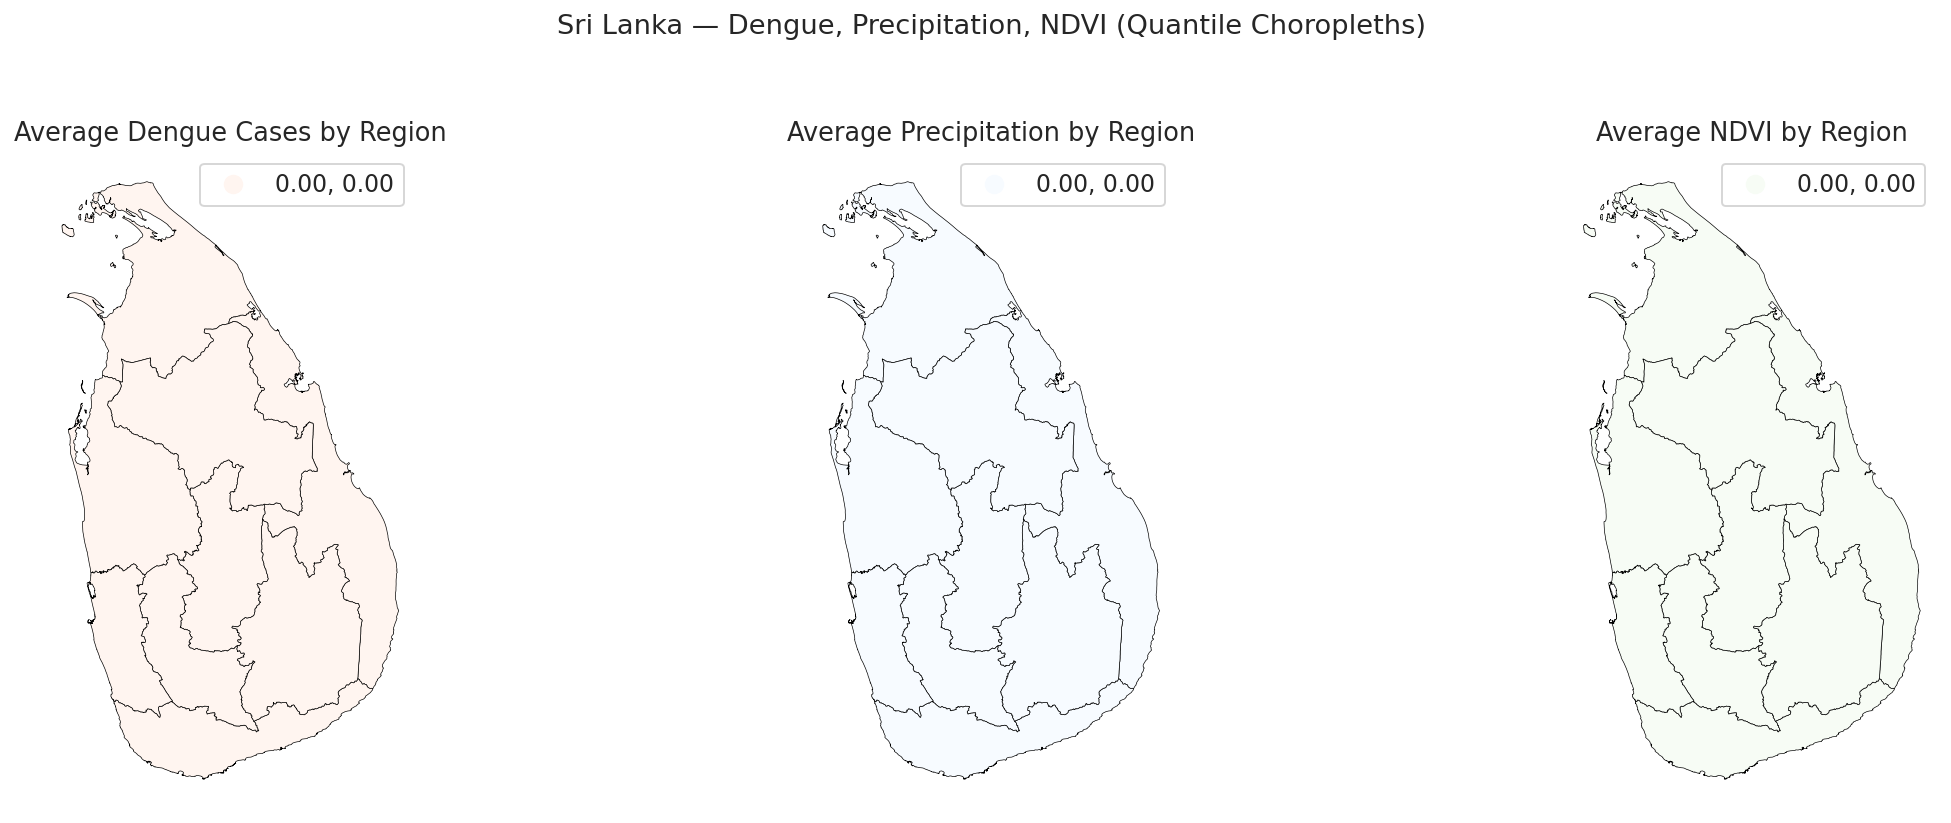

/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


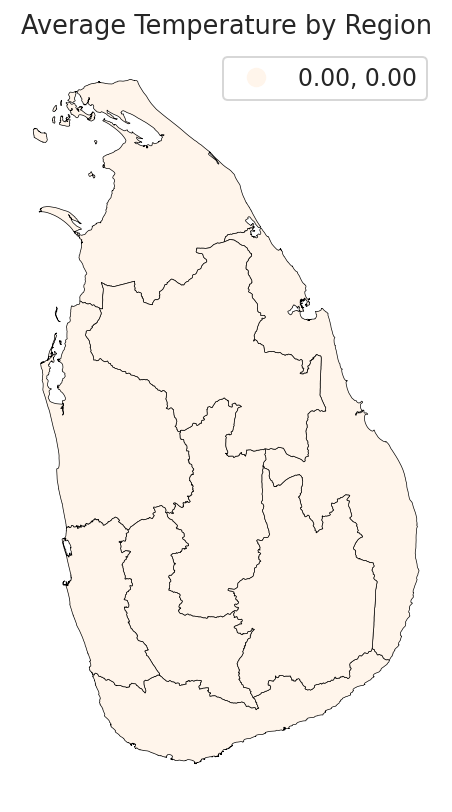

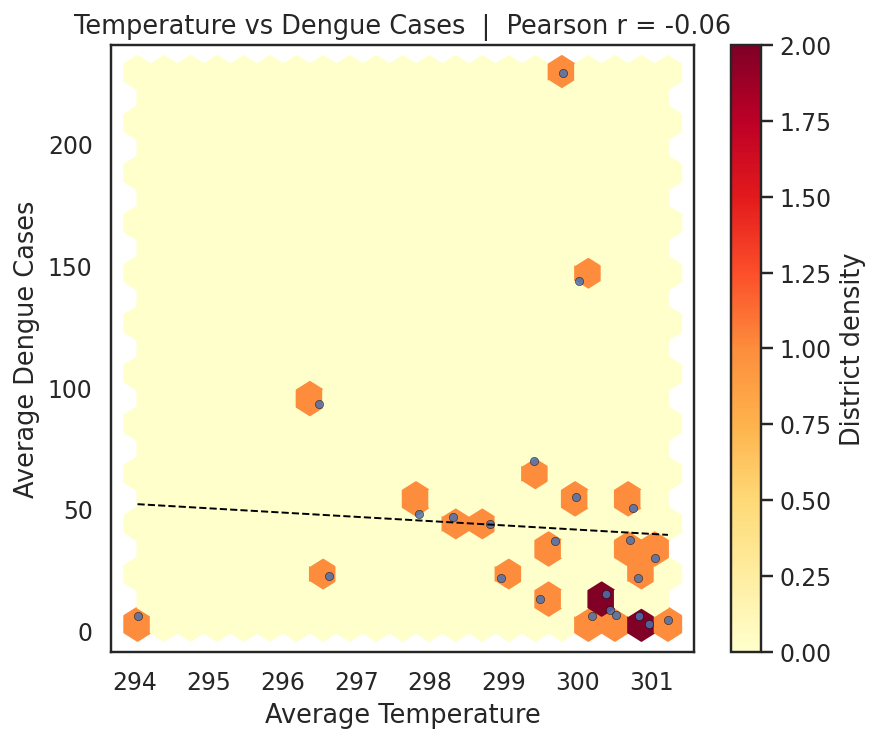


✅ Saved files:
 - sri_lanka_dengue_precip_ndvi_maps.png
 - sri_lanka_temperature_map.png
 - sri_lanka_temp_vs_dengue.png

(If any map still looks monotone, check the 'Matched areas' count and the printed min/max;
 it usually means a name mismatch or a constant column in the joined data.)


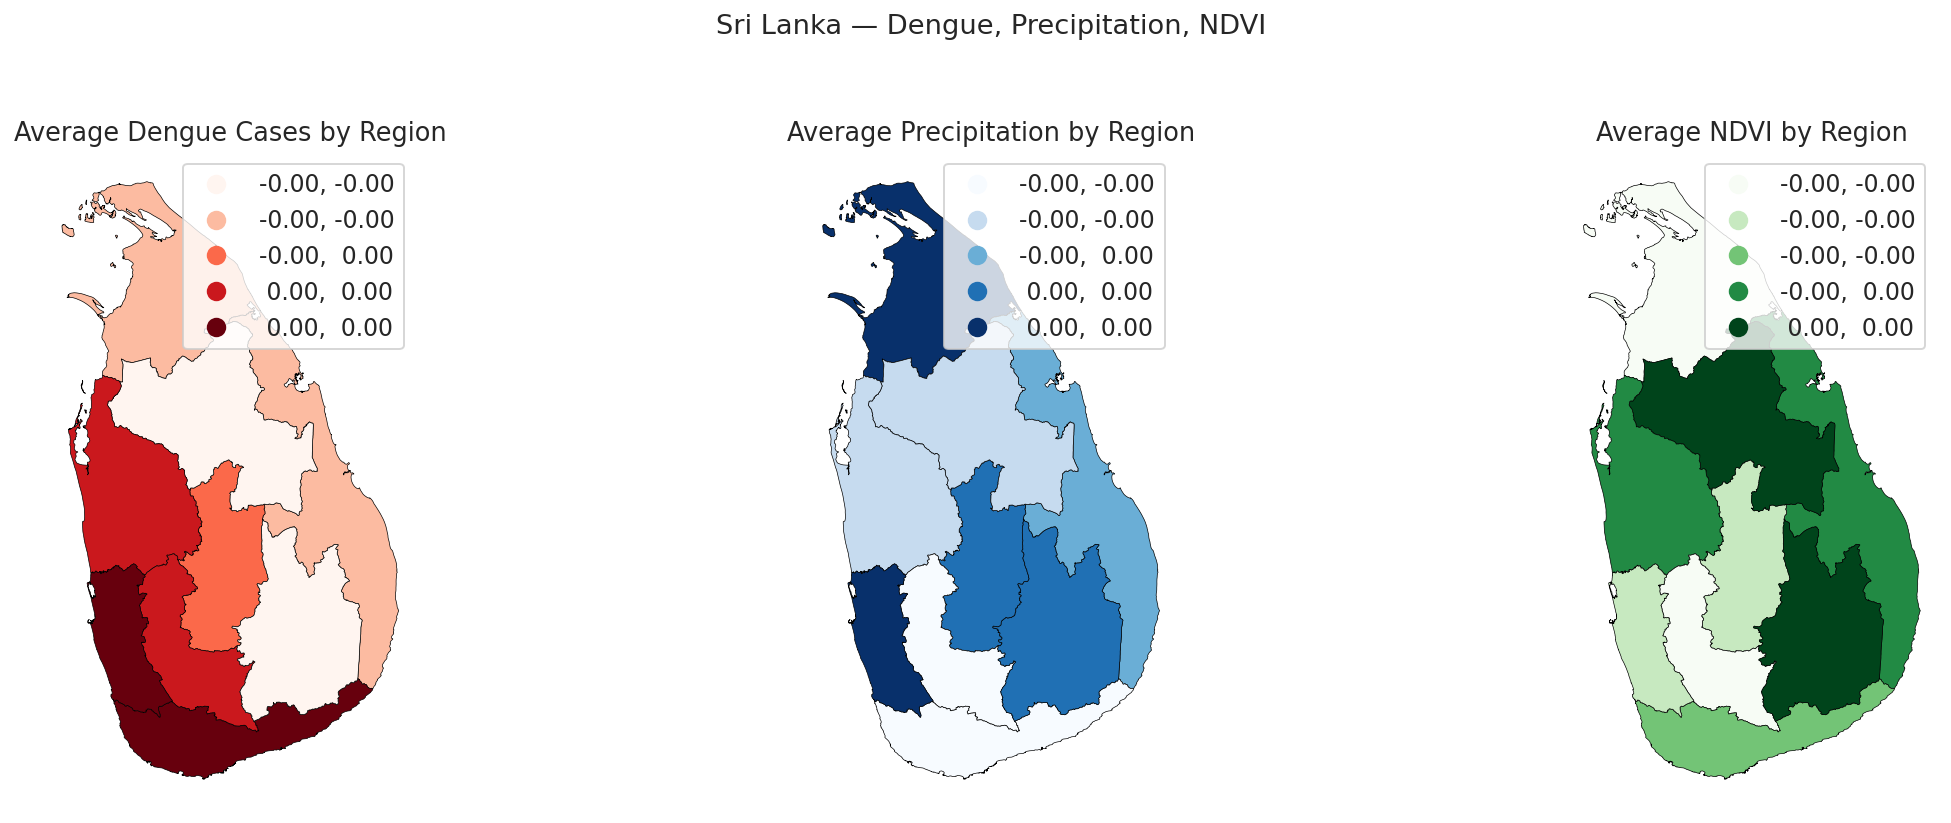

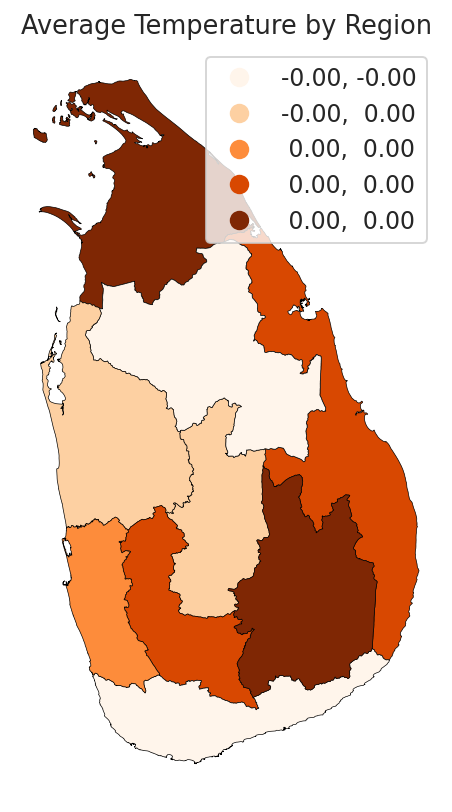

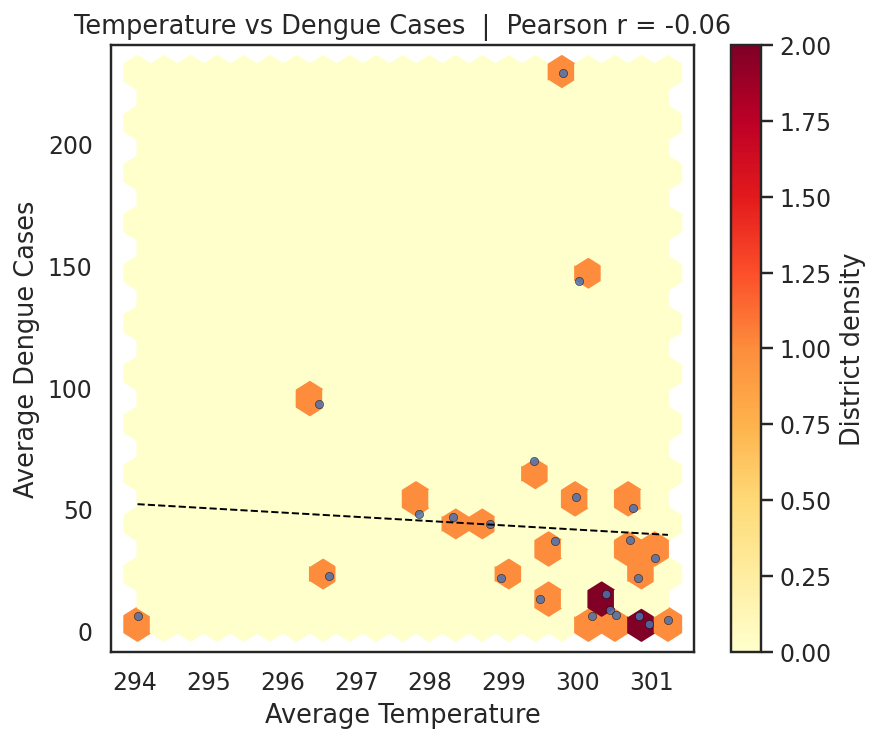

In [16]:
# ================================================================
# Sri Lanka — Dengue, Precipitation, NDVI (repeat)
# + Temperature map and Temperature↔Dengue relationship
# Colab-ready, with robust name matching and visible color breaks
# ================================================================

# 0) Install geo libs (Colab)
!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify

# 1) Imports
import pandas as pd, numpy as np, geopandas as gpd, difflib, re
import matplotlib.pyplot as plt
import mapclassify as mc

plt.rcParams["figure.dpi"] = 140

# 2) File paths — EDIT if yours differ
csv_path     = "/content/SriLanka_dengidata_2013_2022.csv"
geojson_path = "/content/sri_lanka_adm1.geojson"

# 3) Load the tabular data (dengue + EO variables)
df = pd.read_csv(csv_path)
# Remove accidental index columns and strip headers
df = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# 4) Load the Sri Lanka boundary GeoJSON (ADM1 or ADM2)
gdf = gpd.read_file(geojson_path)
gdf.columns = [c.strip() for c in gdf.columns]
print("Geo columns:", list(gdf.columns))

# 5) Detect column names (override here if needed)
# District / region label in CSV
district_xl = next((c for c in df.columns if any(k in c.lower() for k in ["district","region","name"])), None)
if district_xl is None:
    # Fallback: first text column
    text_cols = df.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    if not text_cols:
        raise ValueError("No district/region label column found in CSV.")
    district_xl = text_cols[0]

# Dengue cases
cases_col = next((c for c in df.columns if c.lower() == "cases"), None) \
        or next((c for c in df.columns if "case" in c.lower()), None)
if cases_col is None: raise ValueError("Couldn't find a 'cases' column.")

# NDVI
ndvi_col = next((c for c in df.columns if "ndvi" in c.lower()), None)
if ndvi_col is None: raise ValueError("Couldn't find an NDVI column (e.g., 'meanNdvi').")

# Precipitation (rain)
precip_col = next((c for c in df.columns if any(k in c.lower() for k in ["precip","prcp","rain","rainfall","ppt"])), None)
if precip_col is None: raise ValueError("Couldn't find a precipitation column.")

# Temperature (this is the NEW map + relationship we’re adding)
temp_col = next((c for c in df.columns if any(k in c.lower() for k in ["temp","temperature","tmean","tmax","tmin","tair"])), None)
if temp_col is None: raise ValueError("Couldn't find a temperature column.")

print("\nDetected in CSV:")
print("  District:", district_xl)
print("  Cases   :", cases_col)
print("  NDVI    :", ndvi_col)
print("  Precip  :", precip_col)
print("  Temp    :", temp_col)

# District name in GeoJSON
district_geo = next((c for c in ["shapeName","NAME_1","NAME_2","NAME_EN","name","District","DISTRICT"] if c in gdf.columns), None)
if district_geo is None:
    text_cols_g = gdf.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    district_geo = text_cols_g[0] if text_cols_g else gdf.columns[0]
print("Geo district field:", district_geo)

# 6) Robust name cleaning + fuzzy matching (so the join works and maps color)
def clean_name(s: str):
    if pd.isna(s): return s
    s = str(s).lower().strip()
    s = s.replace("-", " ").replace("_", " ")
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"\b(district|dist|distr|dstrct|ds)\b", "", s).strip()  # strip "district"
    fixes = {  # add more if you find mismatches
        "kaluthara": "kalutara",
        "nuwara-eliya": "nuwara eliya",
        "colombo ": "colombo",
        "gampaha ": "gampaha"
    }
    return fixes.get(s, s)

df["_dkey"]  = df[district_xl].astype(str).map(clean_name)
gdf["_dkey"] = gdf[district_geo].astype(str).map(clean_name)

keys_x = set(df["_dkey"].dropna())
keys_g = set(gdf["_dkey"].dropna())
unmatched = [k for k in keys_x if k not in keys_g]

# Fuzzy map remaining mismatches
fmap = {}
for k in unmatched:
    hit = difflib.get_close_matches(k, list(keys_g), n=1, cutoff=0.76)
    if hit: fmap[k] = hit[0]
df["_dkey_final"]  = df["_dkey"].replace(fmap)
gdf["_dkey_final"] = gdf["_dkey"]

matched = set(df["_dkey_final"]) & set(gdf["_dkey_final"])
print(f"\nMatched areas: {len(matched)} / {len(set(df['_dkey_final']))}")
if len(matched) == 0:
    print("No matches — inspect keys to fix:")
    print("CSV sample:", sorted(list(keys_x))[:10])
    print("Geo sample:", sorted(list(keys_g))[:10])

# 7) Make sure data columns are numeric, then aggregate by district
for c in [cases_col, ndvi_col, precip_col, temp_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

agg = (
    df.groupby("_dkey_final", as_index=False)[[cases_col, ndvi_col, precip_col, temp_col]].mean()
      .rename(columns={cases_col:"cases", ndvi_col:"ndvi", precip_col:"precip", temp_col:"temp"})
)

# 8) Join to geometry
gdfj = gdf.merge(agg, left_on="_dkey_final", right_on="_dkey_final", how="left")

# 9) Correlations (district-level means) — for reference
corrs = agg[["cases","ndvi","precip","temp"]].corr(method="pearson")
ndvi_vs_cases   = float(corrs.loc["cases","ndvi"])
precip_vs_cases = float(corrs.loc["cases","precip"])
temp_vs_cases   = float(corrs.loc["cases","temp"])

print("\nPearson correlations with Dengue (district means):")
print(f"  NDVI vs Dengue          : {ndvi_vs_cases:.3f}")
print(f"  Precipitation vs Dengue : {precip_vs_cases:.3f}")
print(f"  Temperature vs Dengue   : {temp_vs_cases:.3f}")

# 10) Helper to draw choropleths with quantile breaks (guarantees visible colors)
def quantile_choropleth(ax, gdf_, col, title, cmap):
    vals = pd.to_numeric(gdf_[col], errors="coerce")
    if vals.isna().all():
        gdf_[col] = 0.0  # prevent blank map if join failed
    # If column is constant, add tiny jitter to produce breaks
    if vals.notna().sum() > 0 and (vals.max() - vals.min()) == 0:
        gdf_[col] = vals + np.random.normal(0, 1e-9, size=len(vals))
    gdf_.plot(
        column=col, ax=ax, cmap=cmap, legend=True,
        scheme="Quantiles", k=5, linewidth=0.35, edgecolor="black",
        missing_kwds={"color":"lightgray","hatch":"///","label":"No data"}
    )
    ax.set_title(title)
    ax.set_axis_off()

# 11) Recreate the THREE original maps (Dengue, Precipitation, NDVI)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
quantile_choropleth(axes[0], gdfj, "cases",  "Average Dengue Cases by Region", "Reds")
quantile_choropleth(axes[1], gdfj, "precip", "Average Precipitation by Region", "Blues")
quantile_choropleth(axes[2], gdfj, "ndvi",   "Average NDVI by Region", "Greens")
plt.suptitle("Sri Lanka — Dengue, Precipitation, NDVI (Quantile Choropleths)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# 12) NEW map: Temperature choropleth
plt.figure(figsize=(7,6))
ax = plt.gca()
quantile_choropleth(ax, gdfj, "temp", "Average Temperature by Region", "Oranges")
plt.tight_layout()
plt.show()

# 13) Relationship panel: Temperature ↔ Dengue
#    (scatter with regression line + a density feel via hexbin background)
x = agg["temp"].to_numpy()
y = agg["cases"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

plt.figure(figsize=(6.5,5.5))
hb = plt.hexbin(x, y, gridsize=20, cmap="YlOrRd")  # density background
cb = plt.colorbar(hb); cb.set_label("District density")
plt.scatter(x, y, s=18, alpha=0.85, edgecolor="black", linewidths=0.25)  # points
# regression line
if len(x) >= 2:
    m, b = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, m*xx + b, color="black", linestyle="--", linewidth=1)
plt.title(f"Temperature vs Dengue Cases  |  Pearson r = {temp_vs_cases:.2f}")
plt.xlabel("Average Temperature")
plt.ylabel("Average Dengue Cases")
plt.tight_layout()
plt.show()

# 14) Save the key figures for your poster
# a) Three original maps
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1,3,1); quantile_choropleth(ax1, gdfj, "cases",  "Average Dengue Cases by Region", "Reds")
ax2 = fig.add_subplot(1,3,2); quantile_choropleth(ax2, gdfj, "precip", "Average Precipitation by Region", "Blues")
ax3 = fig.add_subplot(1,3,3); quantile_choropleth(ax3, gdfj, "ndvi",   "Average NDVI by Region", "Greens")
plt.suptitle("Sri Lanka — Dengue, Precipitation, NDVI", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("sri_lanka_dengue_precip_ndvi_maps.png", dpi=300)

# b) Temperature map
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1); quantile_choropleth(ax, gdfj, "temp", "Average Temperature by Region", "Oranges")
plt.tight_layout(); plt.savefig("sri_lanka_temperature_map.png", dpi=300)

# c) Temperature↔Dengue relationship
fig = plt.figure(figsize=(6.5,5.5))
hb = plt.hexbin(x, y, gridsize=20, cmap="YlOrRd"); cb = plt.colorbar(hb); cb.set_label("District density")
plt.scatter(x, y, s=18, alpha=0.85, edgecolor="black", linewidths=0.25)
if len(x) >= 2:
    m, b = np.polyfit(x, y, 1); xx = np.linspace(x.min(), x.max(), 100); plt.plot(xx, m*xx + b, color="black", linestyle="--", linewidth=1)
plt.title(f"Temperature vs Dengue Cases  |  Pearson r = {temp_vs_cases:.2f}")
plt.xlabel("Average Temperature"); plt.ylabel("Average Dengue Cases")
plt.tight_layout(); plt.savefig("sri_lanka_temp_vs_dengue.png", dpi=300)

print("\n✅ Saved files:")
print(" - sri_lanka_dengue_precip_ndvi_maps.png")
print(" - sri_lanka_temperature_map.png")
print(" - sri_lanka_temp_vs_dengue.png")
print("\n(If any map still looks monotone, check the 'Matched areas' count and the printed min/max;")
print(" it usually means a name mismatch or a constant column in the joined data.)")


Geo columns: ['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType', 'geometry']

Detected in CSV:
  District: region
  Cases   : cases
  NDVI    : meanNdvi
  Precip  : meanPrecipitationcal
  Temp    : meanTair_F_Inst
Geo district field: shapeName

Matched areas: 0 / 25 (0.0%)
⚠️ Low match rate — colors might be gray. Check name keys printed below.
Sample CSV keys: ['ampara', 'anuradhapura', 'badulla', 'batticaloa', 'colombo', 'galle', 'gampaha', 'hambantota', 'jaffna', 'kalutara', 'kandy', 'kegalle']
Sample Geo keys: ['central province', 'eastern province', 'north central province', 'north western province', 'northern province', 'sabaragamuwa province', 'southern province', 'uva province', 'western province']
cases min/max (joined): nan nan
temp min/max (joined): nan nan
ndvi min/max (joined): nan nan
precip min/max (joined): nan nan

Pearson correlations with Dengue (district means):
  NDVI vs Dengue          : -0.277
  Precipitation vs Dengue : 0.608
  Temperature vs Dengue 

/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


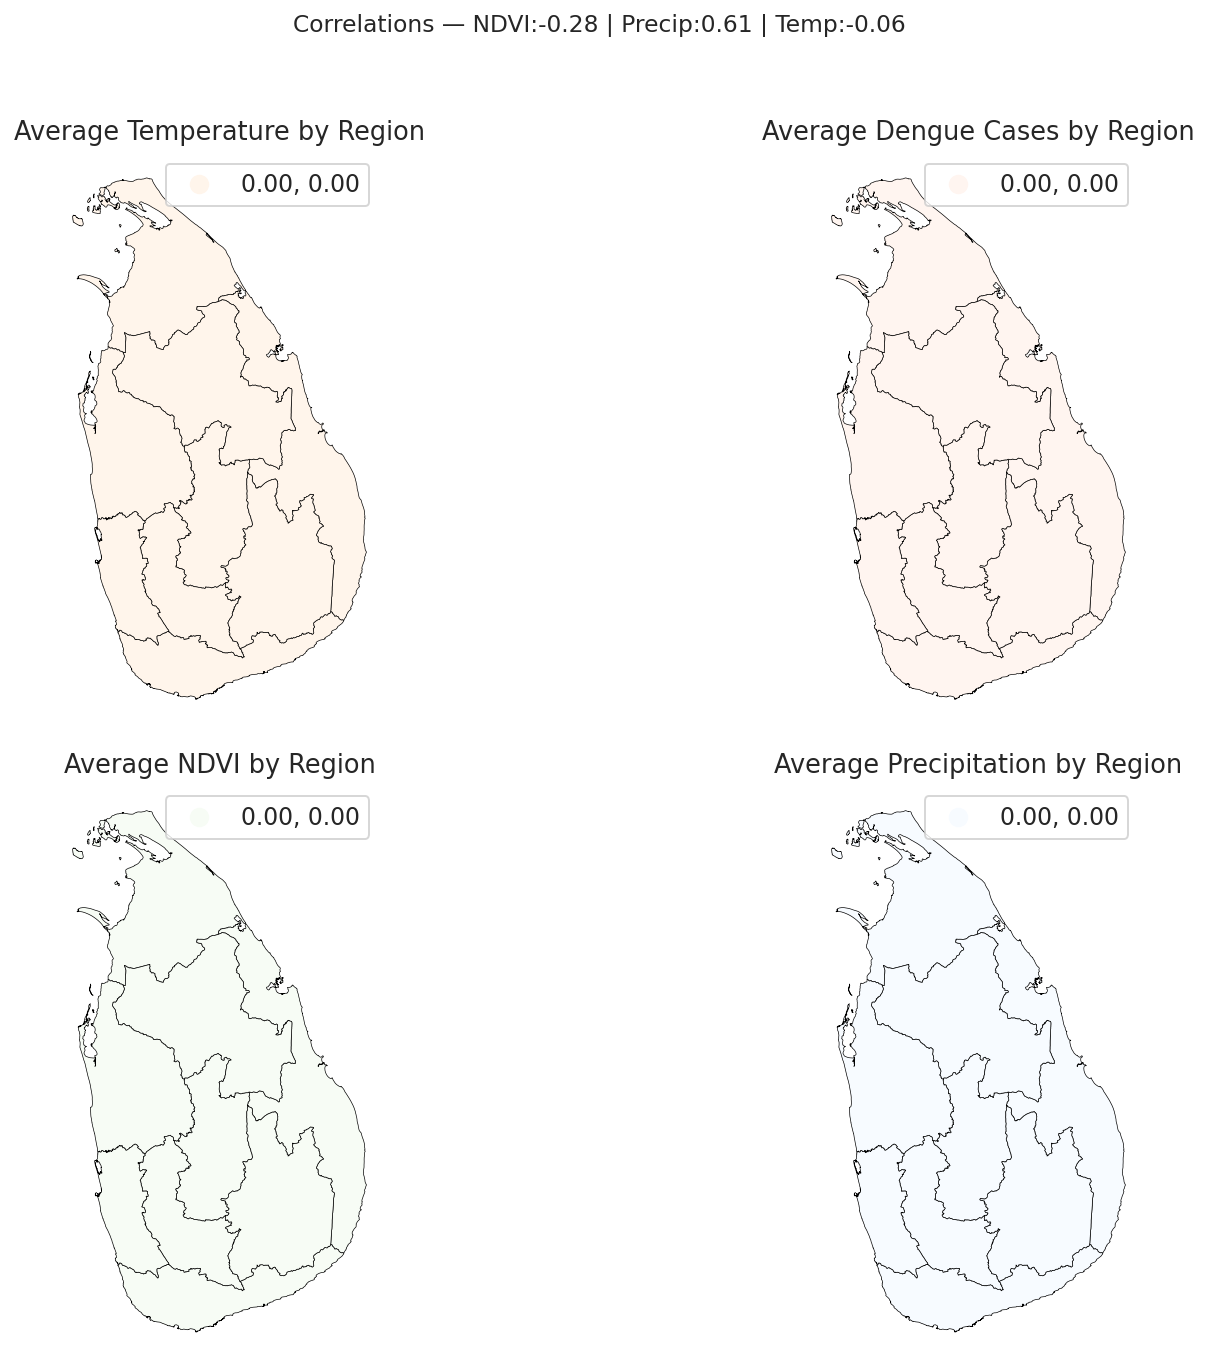

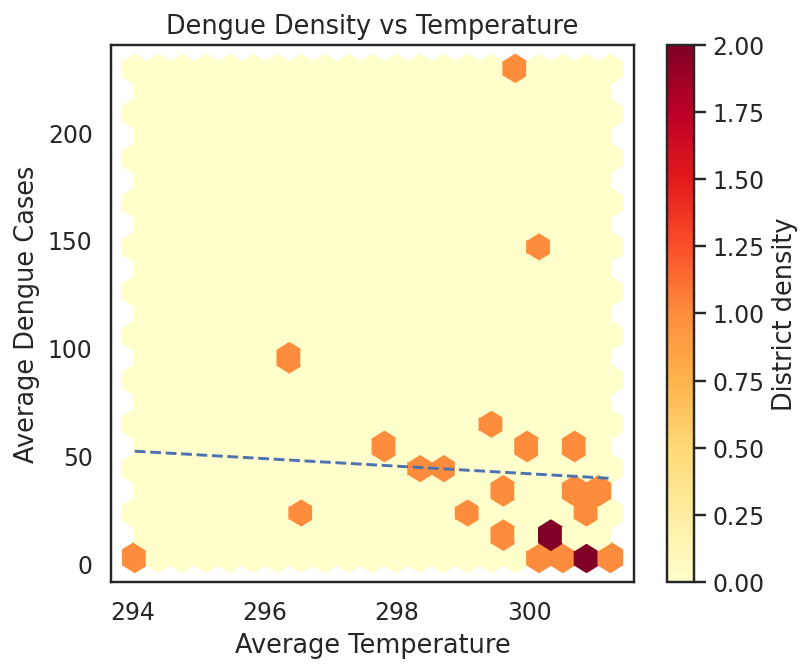

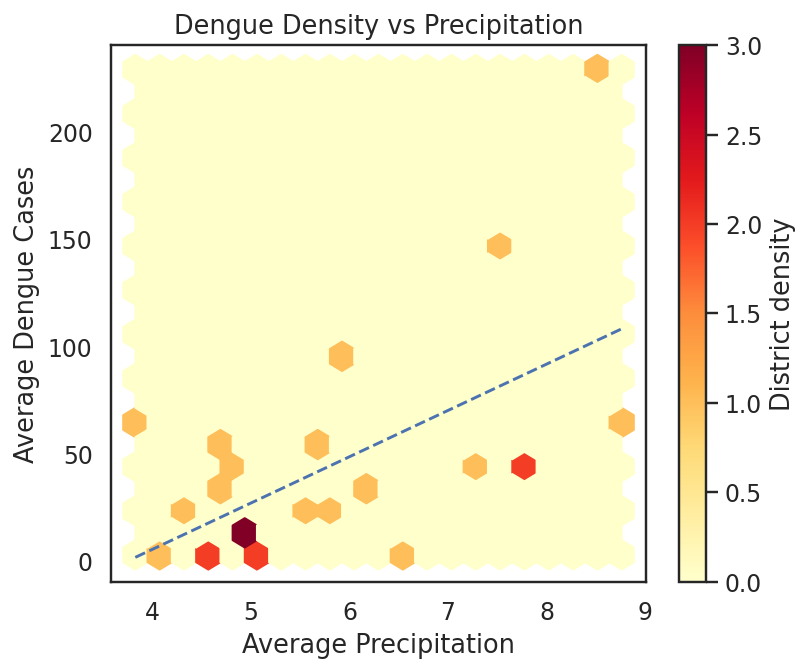

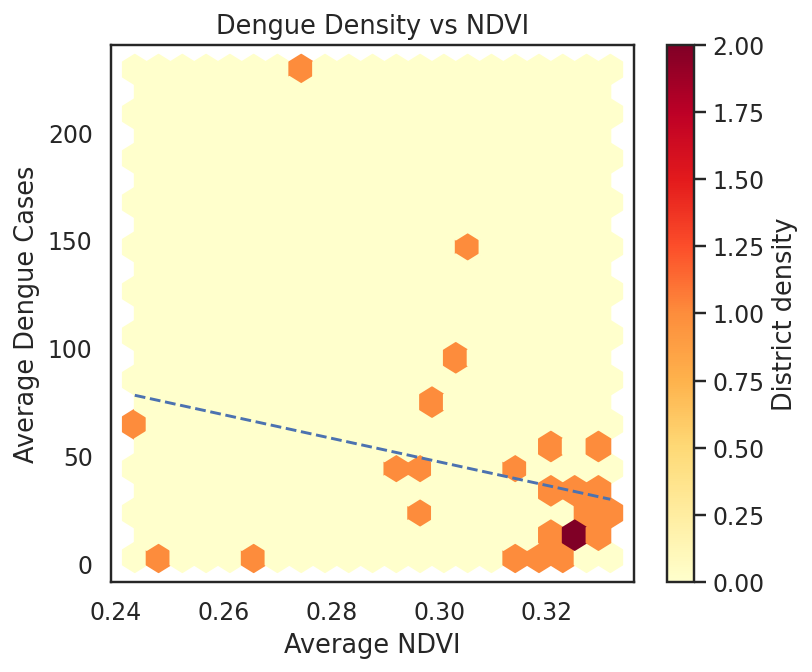

/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/usr/local/lib/python3.12/dist-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 1.
  self.bins = quantile(y, k=k)



Saved: sri_lanka_dengue_ndvi_precip_temp_maps.png


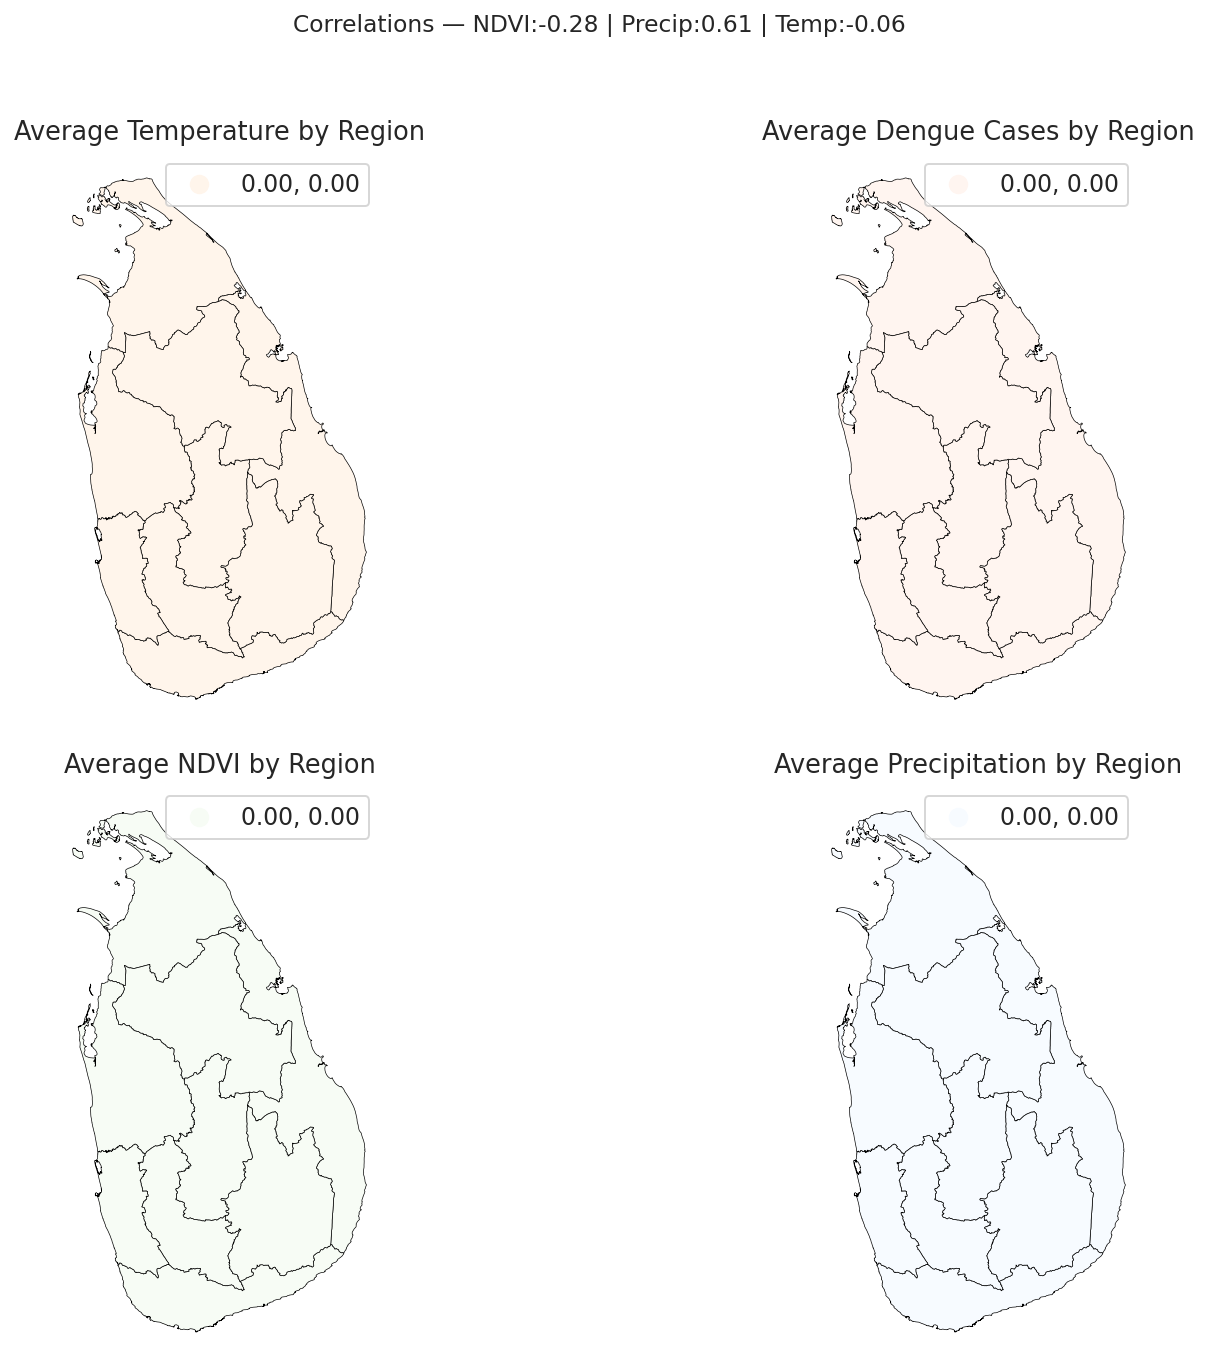

In [17]:
# ================================================================
# Sri Lanka — Dengue vs Temperature/NDVI/Precipitation
# Colored Maps + Correlations + Density Plots (Colab-ready)
# Files used:
#   /content/SriLanka_dengidata_2013_2022.csv
#   /content/sri_lanka_adm1.geojson
# ================================================================

# 0) Install deps (Colab)
!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify scikit-learn

# 1) Imports
import pandas as pd, numpy as np, geopandas as gpd, difflib, re
import matplotlib.pyplot as plt
import mapclassify as mc
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.dpi"] = 140

# 2) Paths — EDIT if your files are elsewhere
csv_path     = "/content/SriLanka_dengidata_2013_2022.csv"
geojson_path = "/content/sri_lanka_adm1.geojson"

# 3) Load data
df  = pd.read_csv(csv_path)
df  = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

gdf = gpd.read_file(geojson_path)
gdf.columns = [c.strip() for c in gdf.columns]

print("Geo columns:", list(gdf.columns))

# 4) Detect key columns in CSV (override here if needed)
district_xl = next((c for c in df.columns if any(k in c.lower() for k in ["district","region","name"])), None)
if district_xl is None:
    text_cols = df.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    if not text_cols:
        raise ValueError("No district/region name column found in CSV.")
    district_xl = text_cols[0]

cases_col = next((c for c in df.columns if c.lower()=="cases"), None) \
        or next((c for c in df.columns if "case" in c.lower()), None)
if cases_col is None:
    raise ValueError("Couldn't find a 'cases' column in CSV.")

ndvi_col = next((c for c in df.columns if "ndvi" in c.lower()), None)
if ndvi_col is None:
    raise ValueError("Couldn't find an NDVI column (e.g., 'meanNdvi').")

precip_col = next((c for c in df.columns if any(k in c.lower() for k in ["precip","prcp","rain","rainfall","ppt"])), None)
if precip_col is None:
    raise ValueError("Couldn't find a precipitation column.")

temp_col = next((c for c in df.columns if any(k in c.lower() for k in ["temp","temperature","tmean","tmax","tmin","tair"])), None)
if temp_col is None:
    raise ValueError("Couldn't find a temperature column.")

print("\nDetected in CSV:")
print("  District:", district_xl)
print("  Cases   :", cases_col)
print("  NDVI    :", ndvi_col)
print("  Precip  :", precip_col)
print("  Temp    :", temp_col)

# 5) District name in GeoJSON (ADM1)
district_geo = None
for cand in ["shapeName","NAME_1","NAME_EN","name","District","DISTRICT"]:
    if cand in gdf.columns:
        district_geo = cand; break
if district_geo is None:
    text_cols_g = gdf.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    district_geo = text_cols_g[0] if text_cols_g else gdf.columns[0]
print("Geo district field:", district_geo)

# ---------- Robust name cleaning & fuzzy matching ----------
def clean_name(s: str):
    if pd.isna(s): return s
    s = str(s).lower().strip()
    s = s.replace("-", " ").replace("_", " ")
    s = re.sub(r"\s+", " ", s)
    # strip common suffixes like "district" etc.
    s = re.sub(r"\b(district|dist|distr|dstrct|ds)\b", "", s).strip()
    # a few frequent manual fixes (add more if you find mismatches)
    fixes = {
        "kaluthara": "kalutara",
        "colombo ": "colombo",
        "nuwara-eliya": "nuwara eliya",
        "gampaha ": "gampaha"
    }
    return fixes.get(s, s)

df["_dkey_raw"]  = df[district_xl].astype(str)
gdf["_dkey_raw"] = gdf[district_geo].astype(str)

df["_dkey"]  = df["_dkey_raw"].map(clean_name)
gdf["_dkey"] = gdf["_dkey_raw"].map(clean_name)

keys_x = set(df["_dkey"].dropna())
keys_g = set(gdf["_dkey"].dropna())
unmatched = [k for k in keys_x if k not in keys_g]

# Fuzzy map only those that fail
fmap = {}
for k in unmatched:
    hit = difflib.get_close_matches(k, list(keys_g), n=1, cutoff=0.76)
    if hit: fmap[k] = hit[0]
df["_dkey_final"]  = df["_dkey"].replace(fmap)
gdf["_dkey_final"] = gdf["_dkey"]

matched = set(df["_dkey_final"]) & set(gdf["_dkey_final"])
match_rate = 100 * len(matched) / max(1, len(set(df["_dkey_final"])))
print(f"\nMatched areas: {len(matched)} / {len(set(df['_dkey_final']))} ({match_rate:.1f}%)")
if match_rate < 70:
    print("⚠️ Low match rate — colors might be gray. Check name keys printed below.")
    print("Sample CSV keys:", sorted(list(set(df['_dkey_final'])))[:12])
    print("Sample Geo keys:", sorted(list(set(gdf['_dkey_final'])))[:12])

# 6) Aggregate by district (mean) and make sure values are numeric
num_cols = [cases_col, ndvi_col, precip_col, temp_col]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

agg = (
    df.groupby("_dkey_final", as_index=False)[num_cols].mean()
      .rename(columns={cases_col:"cases", ndvi_col:"ndvi", precip_col:"precip", temp_col:"temp"})
)

# 7) Join table to geometry
gdfj = gdf.merge(agg, left_on="_dkey_final", right_on="_dkey_final", how="left")

# Diagnostics: check min/max so we know there is variation
def safe_minmax(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s.min(skipna=True), s.max(skipna=True))

for col in ["cases","temp","ndvi","precip"]:
    mn, mx = safe_minmax(gdfj[col])
    print(f"{col} min/max (joined):", mn, mx)

# If a column is constant (min==max), add tiny jitter so quantile bins still show colors
for col in ["cases","temp","ndvi","precip"]:
    s = pd.to_numeric(gdfj[col], errors="coerce")
    if s.notna().sum() > 0 and (s.max() - s.min()) == 0:
        gdfj[col] = s + np.random.normal(0, 1e-9, size=len(s))

# 8) Pearson correlations (district-level means)
corrs = agg[["cases","ndvi","precip","temp"]].corr(method="pearson")
ndvi_vs_cases   = float(corrs.loc["cases","ndvi"])
precip_vs_cases = float(corrs.loc["cases","precip"])
temp_vs_cases   = float(corrs.loc["cases","temp"])

print("\nPearson correlations with Dengue (district means):")
print(f"  NDVI vs Dengue          : {ndvi_vs_cases:.3f}")
print(f"  Precipitation vs Dengue : {precip_vs_cases:.3f}")
print(f"  Temperature vs Dengue   : {temp_vs_cases:.3f}")

# 9) Helper to draw quantile choropleths (guarantees visible color breaks)
def quantile_choropleth(ax, gdf_, col, title, cmap):
    vals = pd.to_numeric(gdf_[col], errors="coerce")
    if vals.isna().all():
        gdf_[col] = 0.0  # avoid blank map if join failed
    gdf_.plot(
        column=col, ax=ax, cmap=cmap, legend=True,
        scheme="Quantiles", k=7,   # 7 bins → more gradation
        linewidth=0.35, edgecolor="black",
        missing_kwds={"color":"lightgray","hatch":"///","label":"No data"}
    )
    ax.set_title(title)
    ax.set_axis_off()

# 10) Choropleth maps — Temperature, Dengue, NDVI, Precipitation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
quantile_choropleth(axes[0,0], gdfj, "temp",   "Average Temperature by Region", "Oranges")
quantile_choropleth(axes[0,1], gdfj, "cases",  "Average Dengue Cases by Region", "Reds")
quantile_choropleth(axes[1,0], gdfj, "ndvi",   "Average NDVI by Region", "Greens")
quantile_choropleth(axes[1,1], gdfj, "precip", "Average Precipitation by Region", "Blues")
plt.suptitle(
    f"Correlations — NDVI:{ndvi_vs_cases:.2f} | Precip:{precip_vs_cases:.2f} | Temp:{temp_vs_cases:.2f}",
    fontsize=12
)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# 11) Density hexbin + regression lines (Dengue vs each variable)
def density_with_reg(x, y, xlabel, ylabel, title):
    x = pd.to_numeric(x, errors="coerce").to_numpy()
    y = pd.to_numeric(y, errors="coerce").to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    plt.figure(figsize=(6,5))
    hb = plt.hexbin(x, y, gridsize=20, cmap="YlOrRd")
    cb = plt.colorbar(hb); cb.set_label("District density")
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    if len(x) >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        plt.plot(xx, m*xx + b, linestyle="--")
    plt.tight_layout(); plt.show()

density_with_reg(agg["temp"],   agg["cases"], "Average Temperature",    "Average Dengue Cases", "Dengue Density vs Temperature")
density_with_reg(agg["precip"], agg["cases"], "Average Precipitation",  "Average Dengue Cases", "Dengue Density vs Precipitation")
density_with_reg(agg["ndvi"],   agg["cases"], "Average NDVI",           "Average Dengue Cases", "Dengue Density vs NDVI")

# 12) Save big PNG with the 4 maps and correlations in the title
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2,2,1); quantile_choropleth(ax1, gdfj, "temp",   "Average Temperature by Region", "Oranges")
ax2 = fig.add_subplot(2,2,2); quantile_choropleth(ax2, gdfj, "cases",  "Average Dengue Cases by Region", "Reds")
ax3 = fig.add_subplot(2,2,3); quantile_choropleth(ax3, gdfj, "ndvi",   "Average NDVI by Region", "Greens")
ax4 = fig.add_subplot(2,2,4); quantile_choropleth(ax4, gdfj, "precip", "Average Precipitation by Region", "Blues")
plt.suptitle(
    f"Correlations — NDVI:{ndvi_vs_cases:.2f} | Precip:{precip_vs_cases:.2f} | Temp:{temp_vs_cases:.2f}",
    fontsize=12
)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("sri_lanka_dengue_ndvi_precip_temp_maps.png", dpi=300)
print("\nSaved: sri_lanka_dengue_ndvi_precip_temp_maps.png")


Geo columns: ['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'geometry']

Detected (Excel):
  District: region
  Cases   : cases
  NDVI    : meanNdvi
  Precip  : meanPrecipitationcal
  Temp    : meanTair_F_Inst
Geo district field: NAME_2

Matched districts: 17 / 24

Pearson correlations with Dengue (district means):
  NDVI vs Dengue       : -0.278
  Precipitation vs Dengue: 0.635
  Temperature vs Dengue : -0.058


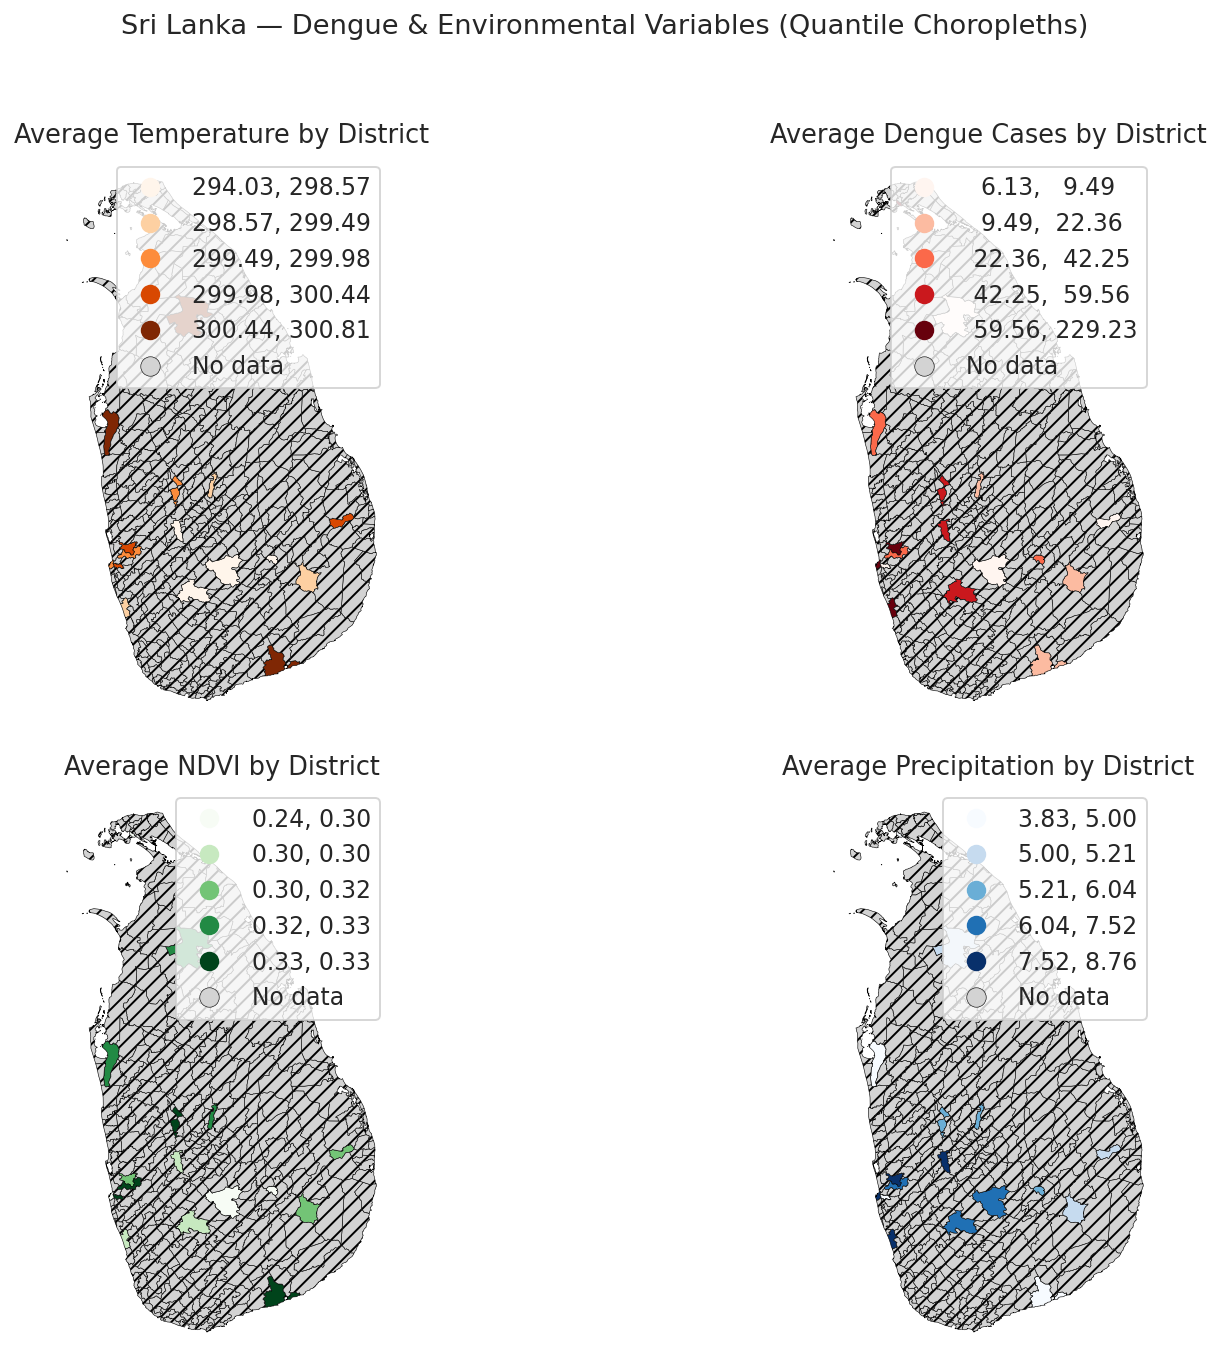


=== Correlation coefficients (Pearson, district-level means) ===
NDVI ↔ Dengue        : -0.278
Precipitation ↔ Dengue: 0.635
Temperature ↔ Dengue  : -0.058

Saved: sri_lanka_dengue_temp_ndvi_precip_maps.png


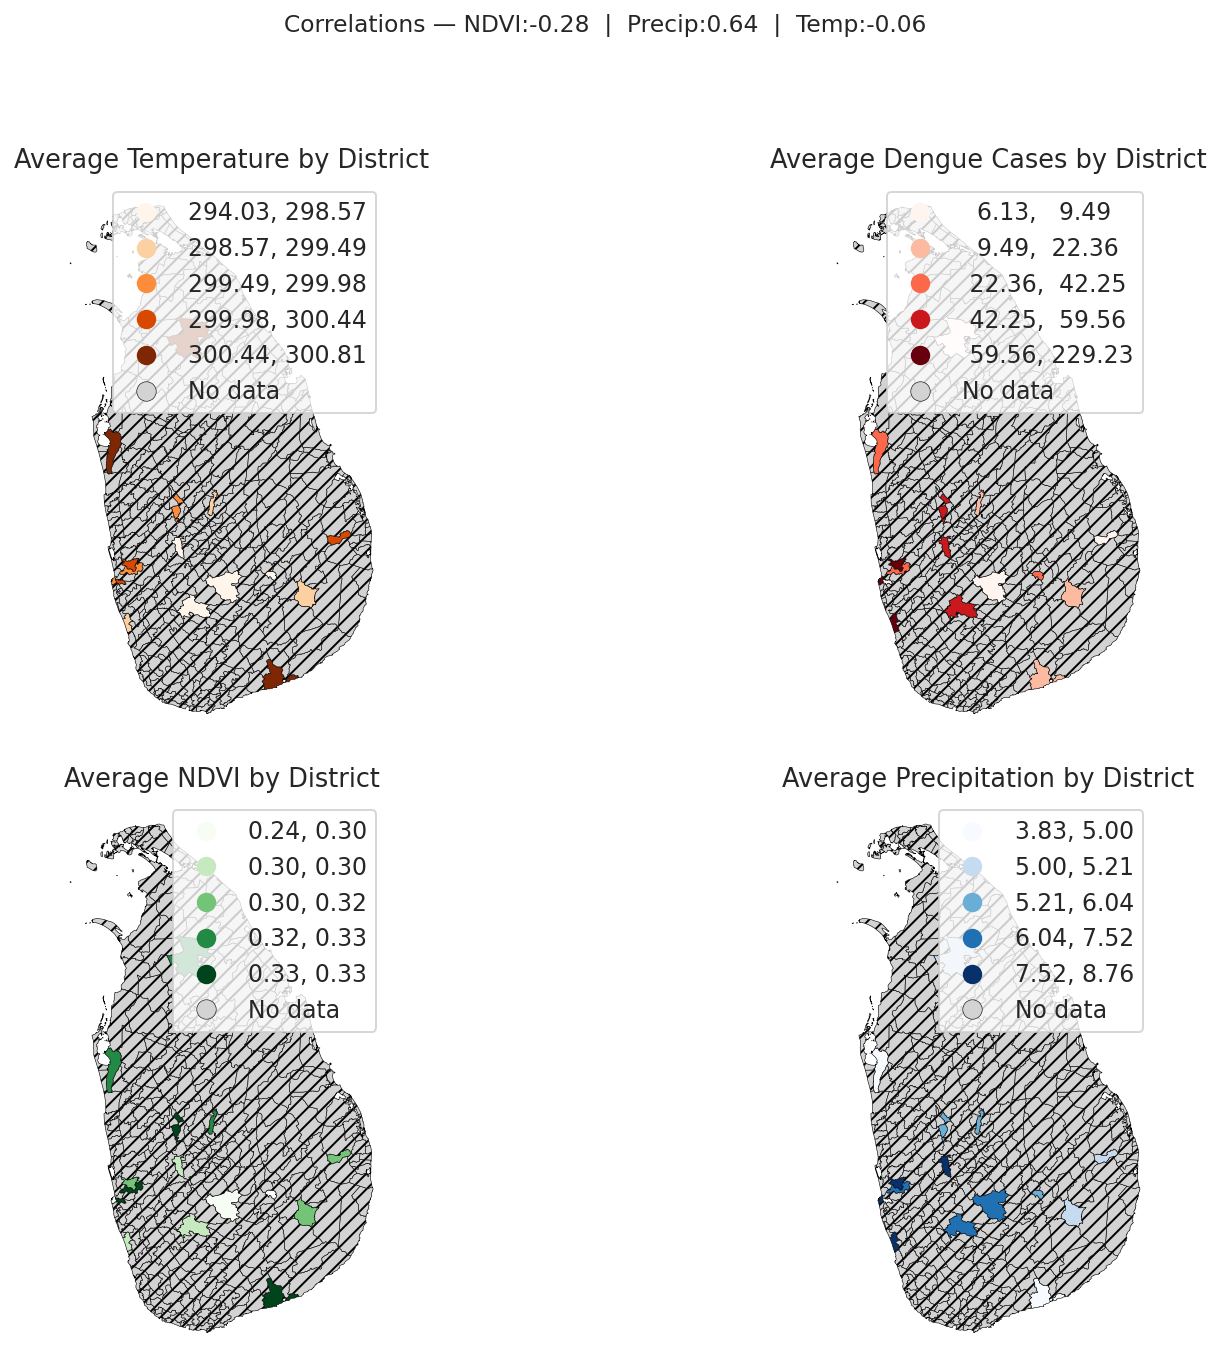

In [18]:
# ================================================================
# Sri Lanka — Maps for Dengue, Temperature, NDVI, Precipitation
# + Correlations with Dengue
# Files: dengue_cleaned.xlsx (tabular), gadm41_LKA_2.json (district polygons)
# ================================================================

# 0) Install deps (Colab)
!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify

# 1) Imports
import pandas as pd, numpy as np, geopandas as gpd, difflib
import matplotlib.pyplot as plt
import mapclassify as mc

plt.rcParams["figure.dpi"] = 140

# 2) Paths (edit if your files are elsewhere)
excel_path   = "/content/dengue_cleaned.xlsx"
geojson_path = "/content/gadm41_LKA_2.json"

# 3) Load data
df  = pd.read_excel(excel_path)
df  = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

gdf = gpd.read_file(geojson_path)
gdf.columns = [c.strip() for c in gdf.columns]

print("Geo columns:", list(gdf.columns))

# 4) Detect key columns in Excel (adjust if needed)
district_xl = next((c for c in df.columns if any(k in c.lower() for k in ["district","region","name"])), None)
if district_xl is None:
    # fallback to first text column
    text_cols = df.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    if not text_cols:
        raise ValueError("No district/region name column found in the Excel.")
    district_xl = text_cols[0]

# Dengue cases
cases_col = next((c for c in df.columns if c.lower()=="cases"), None)
if cases_col is None:
    cases_col = next((c for c in df.columns if "case" in c.lower()), None)
if cases_col is None:
    raise ValueError("Couldn't find a 'cases' column in Excel.")

# NDVI
ndvi_col = next((c for c in df.columns if "ndvi" in c.lower()), None)
if ndvi_col is None:
    raise ValueError("Couldn't find an NDVI column (e.g., 'meanNdvi').")

# Precipitation
precip_col = next((c for c in df.columns if any(k in c.lower() for k in ["precip","prcp","rain","rainfall","ppt"])), None)
if precip_col is None:
    raise ValueError("Couldn't find a precipitation column.")

# Temperature
temp_col = next((c for c in df.columns if any(k in c.lower() for k in ["temp","temperature","tmean","tmax","tmin","tair"])), None)
if temp_col is None:
    raise ValueError("Couldn't find a temperature column.")

print("\nDetected (Excel):")
print("  District:", district_xl)
print("  Cases   :", cases_col)
print("  NDVI    :", ndvi_col)
print("  Precip  :", precip_col)
print("  Temp    :", temp_col)

# District name in GeoJSON (GADM L2 commonly NAME_2)
district_geo = None
for cand in ["NAME_2","name_2","NAME_3","NAME_EN","name","shapeName","District","DISTRICT"]:
    if cand in gdf.columns:
        district_geo = cand
        break
if district_geo is None:
    # fallback to first text-like column
    text_cols_g = gdf.select_dtypes(exclude=["number","bool","datetime"]).columns.tolist()
    district_geo = text_cols_g[0] if text_cols_g else gdf.columns[0]
print("Geo district field:", district_geo)

# 5) Normalize names + fuzzy match for joining
def norm(s):
    if pd.isna(s): return s
    s = str(s).strip().lower().replace("-"," ").replace("_"," ")
    s = " ".join(s.split())
    return s

df["_dkey"]  = df[district_xl].map(norm)
gdf["_dkey"] = gdf[district_geo].map(norm)

keys_x = set(df["_dkey"].dropna())
keys_g = set(gdf["_dkey"].dropna())
unmatched = [k for k in keys_x if k not in keys_g]

fmap = {}
for k in unmatched:
    hit = difflib.get_close_matches(k, list(keys_g), n=1, cutoff=0.78)
    if hit:
        fmap[k] = hit[0]
df["_dkey_final"]  = df["_dkey"].replace(fmap)
gdf["_dkey_final"] = gdf["_dkey"]

matched = set(df["_dkey_final"]) & set(gdf["_dkey_final"])
print(f"\nMatched districts: {len(matched)} / {len(set(df['_dkey_final']))}")
if len(matched) == 0:
    print("No matches — inspect a few keys:")
    print("Excel sample:", list(keys_x)[:10])
    print("Geo sample  :", list(keys_g)[:10])

# 6) Aggregate by district (mean) and join
agg = (
    df.groupby("_dkey_final", as_index=False)
      .agg({cases_col:"mean", ndvi_col:"mean", precip_col:"mean", temp_col:"mean"})
      .rename(columns={cases_col:"cases", ndvi_col:"ndvi", precip_col:"precip", temp_col:"temp"})
)
gdfj = gdf.merge(agg, left_on="_dkey_final", right_on="_dkey_final", how="left")

# 7) Correlations (Pearson) — print clearly
corrs = agg[["cases","ndvi","precip","temp"]].corr(method="pearson")
ndvi_vs_cases   = corrs.loc["cases","ndvi"]
precip_vs_cases = corrs.loc["cases","precip"]
temp_vs_cases   = corrs.loc["cases","temp"]

print("\nPearson correlations with Dengue (district means):")
print(f"  NDVI vs Dengue       : {ndvi_vs_cases:.3f}")
print(f"  Precipitation vs Dengue: {precip_vs_cases:.3f}")
print(f"  Temperature vs Dengue : {temp_vs_cases:.3f}")

# 8) Simple function to draw a quantile choropleth (guarantees visible colors)
def choropleth(ax, gdf_, col, title, cmap):
    col_vals = pd.to_numeric(gdf_[col], errors="coerce")
    if col_vals.isna().all():
        gdf_[col] = 0.0  # prevent blank plot if join failed
    gdf_.plot(
        column=col, ax=ax, cmap=cmap, legend=True,
        scheme="Quantiles", k=5,
        linewidth=0.3, edgecolor="black",
        missing_kwds={"color":"lightgray","hatch":"///","label":"No data"}
    )
    ax.set_title(title)
    ax.set_axis_off()

# 9) Make the requested maps:
#    - Temperature map
#    - Dengue cases map
#    - NDVI map
#    - Precipitation map
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
choropleth(axes[0,0], gdfj, "temp",   "Average Temperature by District", "Oranges")
choropleth(axes[0,1], gdfj, "cases",  "Average Dengue Cases by District", "Reds")
choropleth(axes[1,0], gdfj, "ndvi",   "Average NDVI by District", "Greens")
choropleth(axes[1,1], gdfj, "precip", "Average Precipitation by District", "Blues")
plt.suptitle("Sri Lanka — Dengue & Environmental Variables (Quantile Choropleths)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# 10) Also display the correlations prominently under the maps
print("\n=== Correlation coefficients (Pearson, district-level means) ===")
print(f"NDVI ↔ Dengue        : {ndvi_vs_cases:.3f}")
print(f"Precipitation ↔ Dengue: {precip_vs_cases:.3f}")
print(f"Temperature ↔ Dengue  : {temp_vs_cases:.3f}")

# 11) Save a PNG with the 4 maps (for your poster)
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2,2,1); choropleth(ax1, gdfj, "temp",   "Average Temperature by District", "Oranges")
ax2 = fig.add_subplot(2,2,2); choropleth(ax2, gdfj, "cases",  "Average Dengue Cases by District", "Reds")
ax3 = fig.add_subplot(2,2,3); choropleth(ax3, gdfj, "ndvi",   "Average NDVI by District", "Greens")
ax4 = fig.add_subplot(2,2,4); choropleth(ax4, gdfj, "precip", "Average Precipitation by District", "Blues")
plt.suptitle(
    f"Correlations — NDVI:{ndvi_vs_cases:.2f}  |  Precip:{precip_vs_cases:.2f}  |  Temp:{temp_vs_cases:.2f}",
    fontsize=12
)
plt.tight_layout(rect=[0,0,1,0.94])
plt.savefig("sri_lanka_dengue_temp_ndvi_precip_maps.png", dpi=300)
print("\nSaved: sri_lanka_dengue_temp_ndvi_precip_maps.png")


Detected columns:
region cases meanNdvi meanPrecipitationcal meanTair_F_Inst shapeName

Head of joined GeoDataFrame (gdfj):


shapeName shapeISO                  shapeID shapeGroup  \
0       Northern Province     LK-4  99731895B93054189817547        LKA   
1        Eastern Province     LK-5  99731895B51072878877669        LKA   
2        Central Province     LK-2  99731895B28050807675820        LKA   
3  North Central Province     LK-7  99731895B66209916164902        LKA   
4  North Western Province     LK-6   99731895B5260290378804        LKA   

  shapeType                                           geometry  \
0      ADM1  MULTIPOLYGON (((79.91381 8.94183, 79.91379 8.9...   
1      ADM1  POLYGON ((80.75304 8.90515, 80.78104 8.91667, ...   
2      ADM1  POLYGON ((80.98913 7.72169, 80.98844 7.72144, ...   
3      ADM1  POLYGON ((80.03237 8.52721, 80.03268 8.52444, ...   
4      ADM1  MULTIPOLYGON (((79.77994 8.26209, 79.78165 8.2...   

                    _dkey               _province      cases      ndvi  \
0       northern province       northern province  16.249160  0.293586   
1        eastern province        eastern province  28.902661  0.320842   
2        central province        central province  57.711134  0.314974   
3  north central province  north central province  11.918067  0.327122   
4  north western province  north western province  46.344538  0.327233   

     precip        temp  
0  4.398457  300.888020  
1  4.796706  300.668989  
2  5.678535  297.728495  
3  4.999716  300.411900  
4  5.220957  300.344681


Correlation matrix:
            cases      ndvi    precip      temp
cases   1.000000 -0.423992  0.802197 -0.129398
ndvi   -0.423992  1.000000 -0.506111  0.249461
precip  0.802197 -0.506111  1.000000 -0.426333
temp   -0.129398  0.249461 -0.426333  1.000000


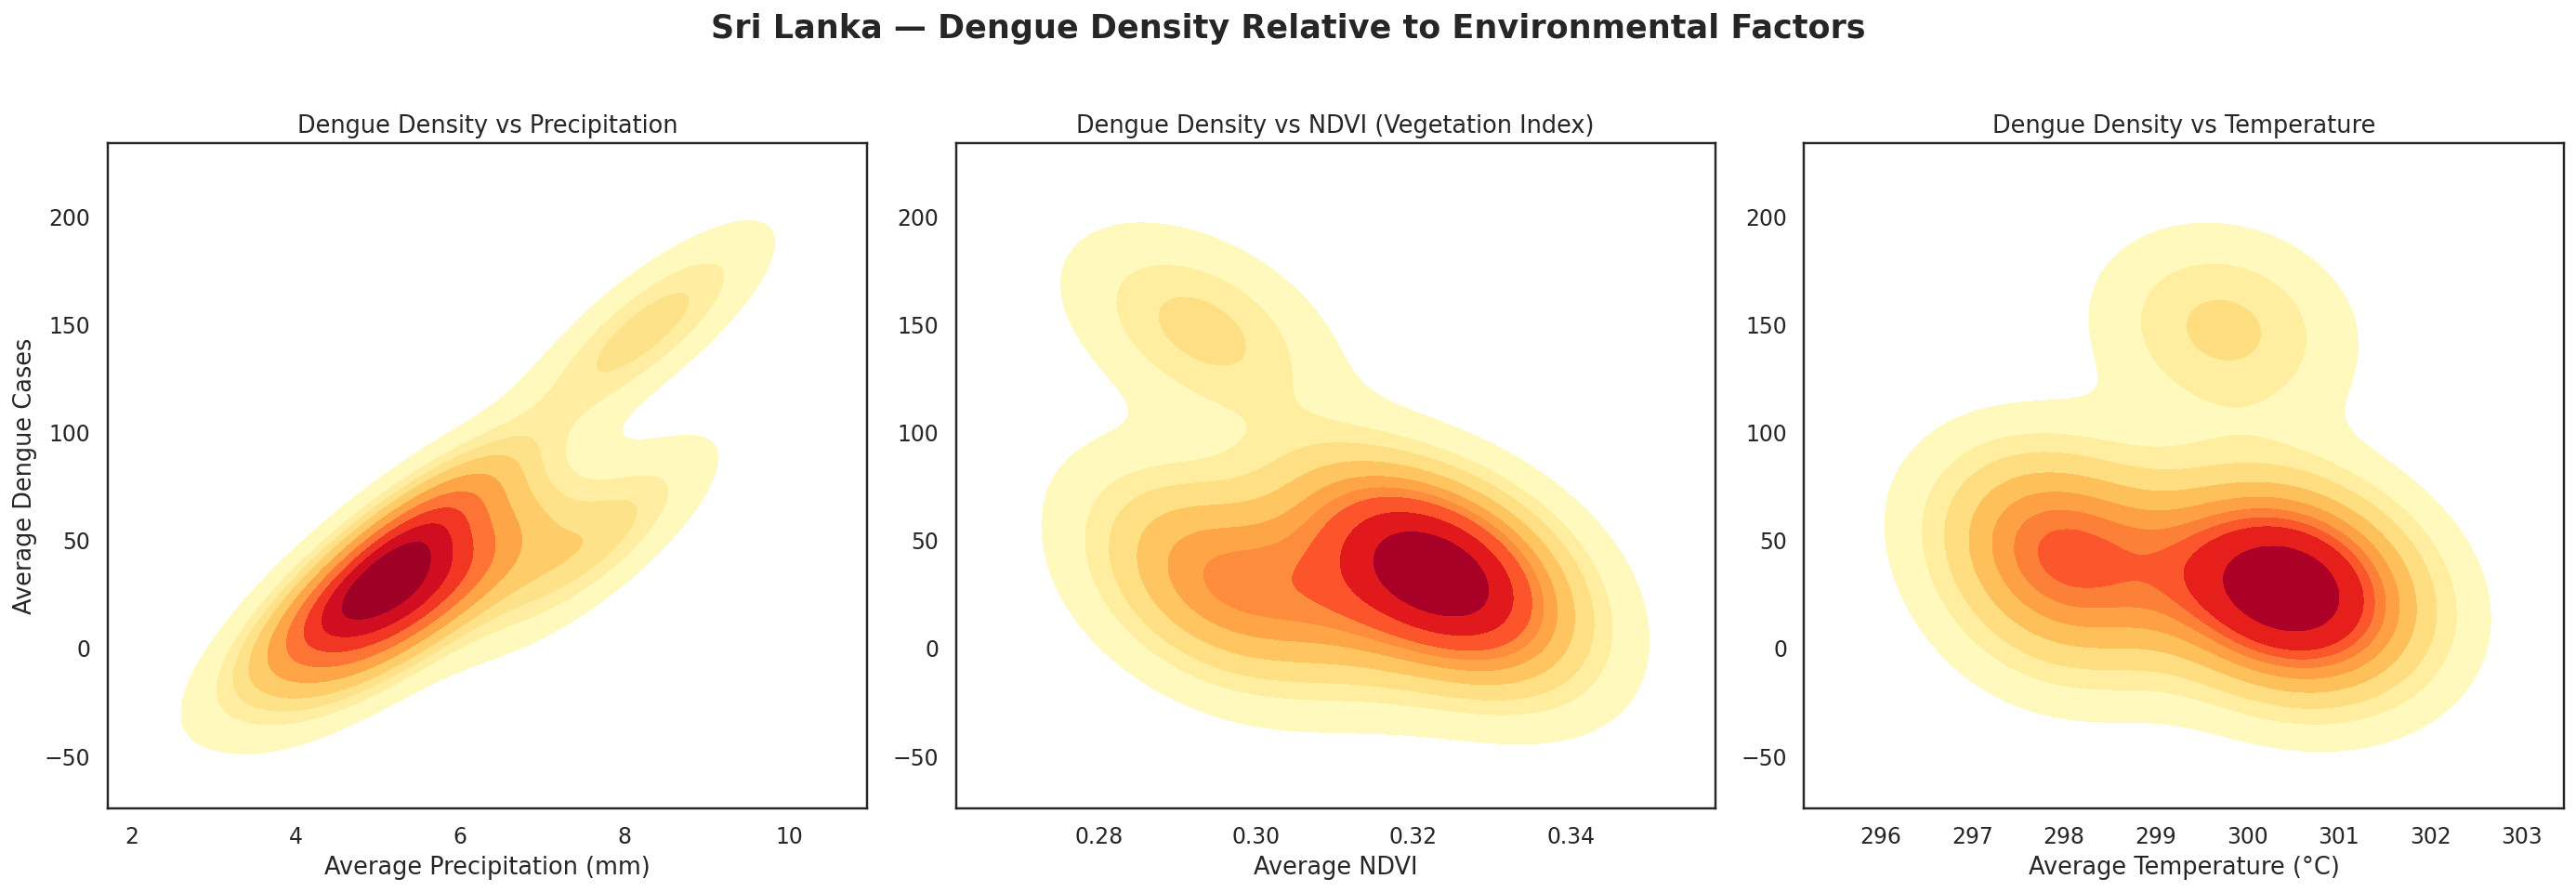

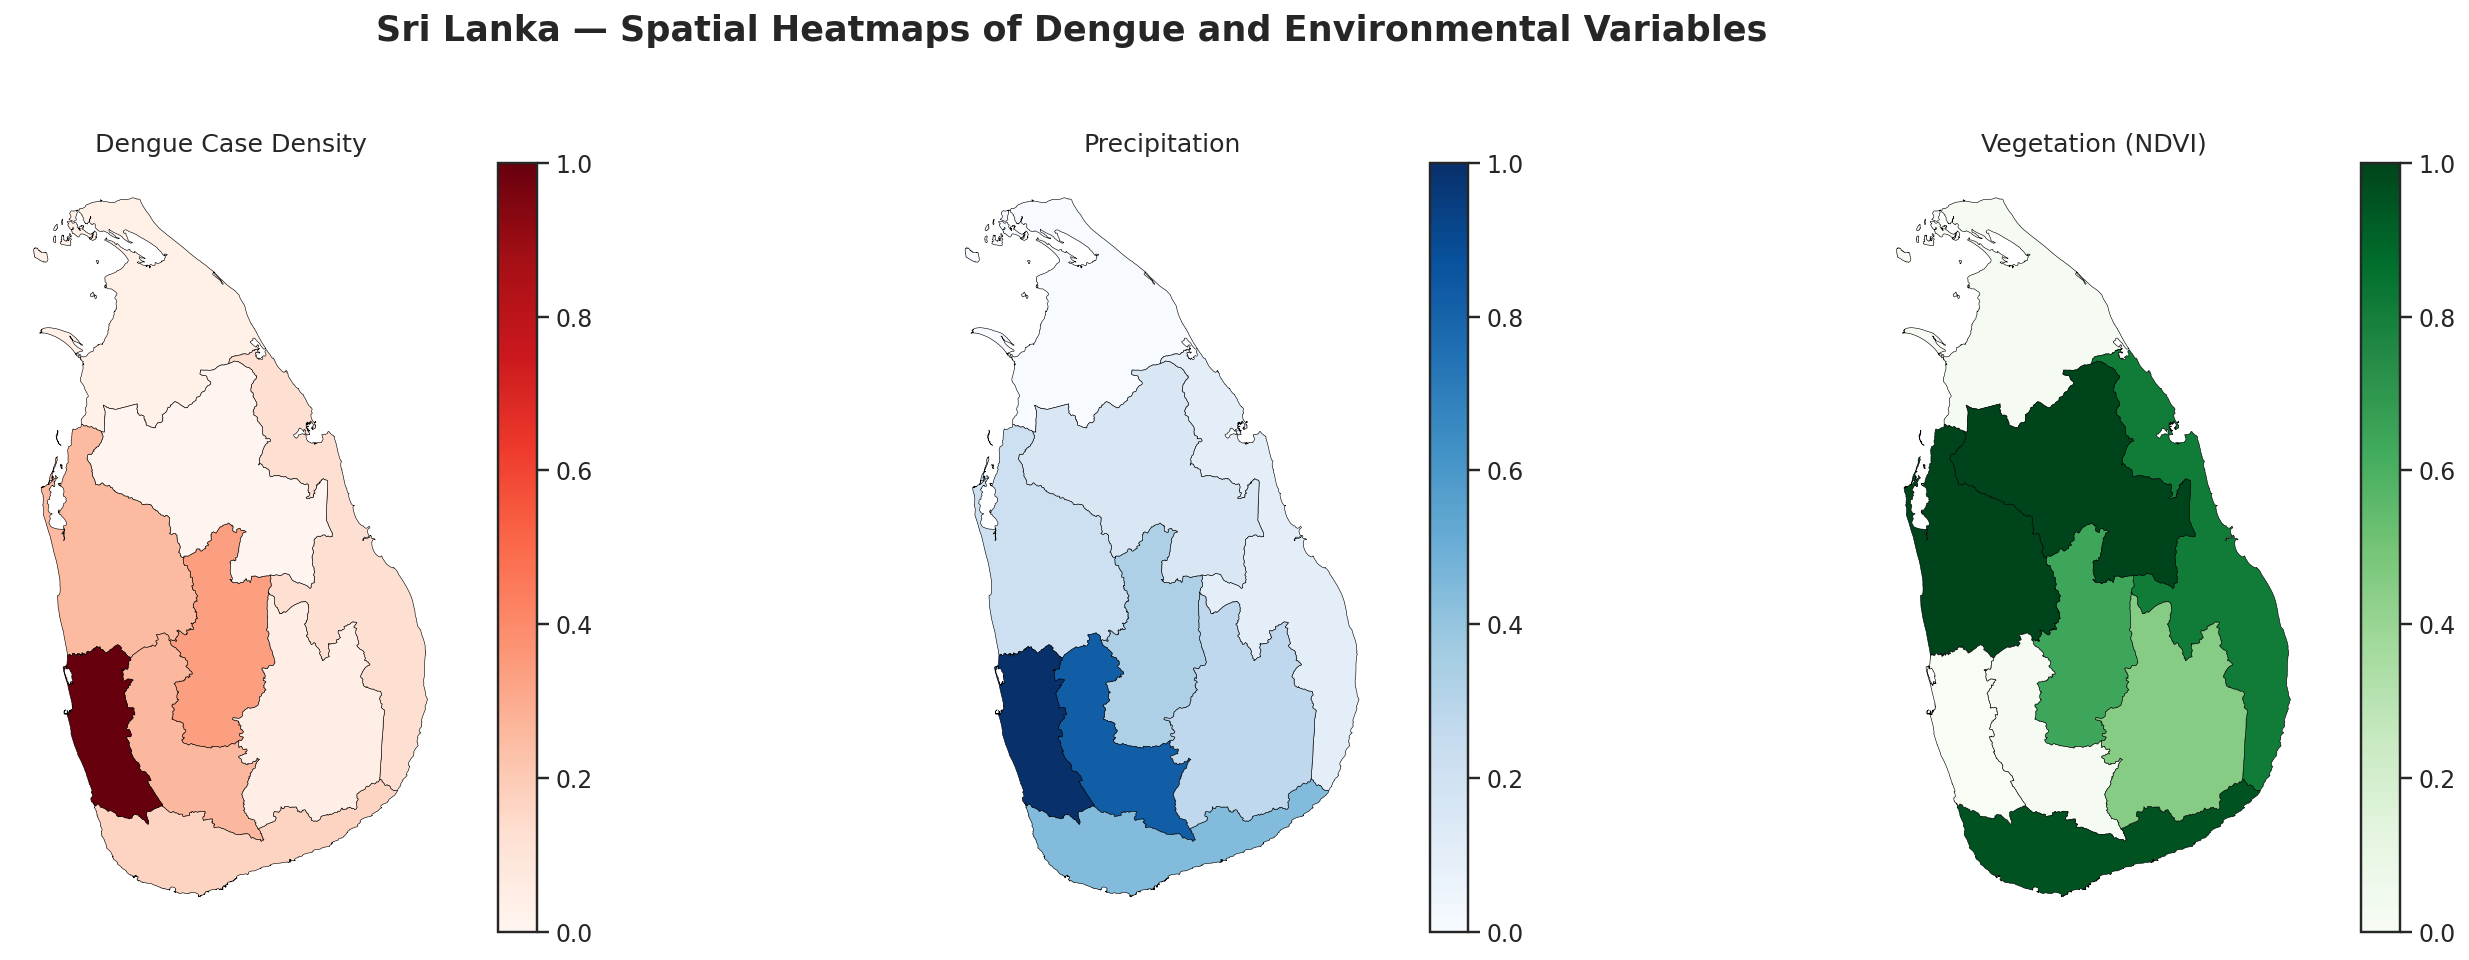

In [19]:
# ================================================================
# Sri Lanka Dengue Heatmaps vs NDVI, Precipitation, and Temperature
# ================================================================

!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify scikit-learn

import pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt, difflib
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(style="white", font_scale=1.1)

# ---------- 1) Load Data ----------
excel_path = "/content/dengue_cleaned.xlsx"
geojson_path = "/content/sri_lanka_adm1.geojson"   # upload to /content/

# Load data (using the already loaded dataframe and geodataframe)
# df = pd.read_excel(excel_path)
df = pd.read_csv("/content/SriLanka_dengidata_2013_2022.csv")
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# gdf = gpd.read_file(geojson_path)
gdf = gpd.read_file("/content/sri_lanka_adm1.geojson")
gdf.columns = [c.strip() for c in gdf.columns]


# ---------- 2) Identify columns ----------
district_xl = [c for c in df.columns if "district" in c.lower() or "region" in c.lower()][0]
cases_col   = [c for c in df.columns if "case" in c.lower()][0]
ndvi_col    = [c for c in df.columns if "ndvi" in c.lower()][0]
precip_col  = [c for c in df.columns if "precip" in c.lower() or "rain" in c.lower()][0]
temp_col    = [c for c in df.columns if "temp" in c.lower() or "tair" in c.lower()][0] # Added 'tair'
# district_geo = [c for c in gdf.columns if "shape" in c.lower() or "name" in c.lower()][0]
district_geo = "shapeName" # Explicitly set the column name


print("Detected columns:")
print(district_xl, cases_col, ndvi_col, precip_col, temp_col, district_geo)

# ---------- 3) Standardize district names + fuzzy match ----------
def norm(s):
    if pd.isna(s): return s
    s=str(s).strip().lower().replace("-"," ").replace("_"," ")
    s=" ".join(s.split())
    return s

df["_dkey"]=df[district_xl].map(norm)
gdf["_dkey"]=gdf[district_geo].map(norm)
unmatched=[k for k in df["_dkey"].unique() if k not in gdf["_dkey"].unique()]
fmap={u:difflib.get_close_matches(u,gdf["_dkey"].unique(),n=1,cutoff=0.75)[0]
      for u in unmatched if difflib.get_close_matches(u,gdf["_dkey"].unique(),n=1,cutoff=0.75)}
df["_dkey"]=df["_dkey"].replace(fmap)

# --- Mapping districts to provinces for aggregation ---
# This is a manual mapping based on common knowledge of Sri Lanka's administrative divisions.
# If your data or GeoJSON uses a different administrative level or naming, this mapping might need adjustment.
district_to_province = {
    'ampara': 'eastern province',
    'anuradhapura': 'north central province',
    'badulla': 'uva province',
    'batticaloa': 'eastern province',
    'colombo': 'western province',
    'galle': 'southern province',
    'gampaha': 'western province',
    'hambantota': 'southern province',
    'jaffna': 'northern province',
    'kalutara': 'western province',
    'kandy': 'central province',
    'kegalle': 'sabaragamuwa province',
    'kilinochchi': 'northern province',
    'kurunegala': 'north western province',
    'mannar': 'northern province',
    'matale': 'central province',
    'matara': 'southern province',
    'moneragala': 'uva province',
    'mullaitivu': 'northern province',
    'nuwara eliya': 'central province', # Using the normalized name
    'polonnaruwa': 'north central province',
    'puttalam': 'north western province',
    'ratnapura': 'sabaragamuwa province',
    'trincomalee': 'eastern province',
    'vavuniya': 'northern province'
}

df['_province'] = df['_dkey'].map(district_to_province)


# ---------- 4) Aggregate by province ----------
# Now aggregate by the new province column
agg=df.groupby("_province",as_index=False)[[cases_col,ndvi_col,precip_col,temp_col]].mean()
agg.rename(columns={cases_col:"cases",ndvi_col:"ndvi",precip_col:"precip",temp_col:"temp"},inplace=True)

# ---------- 5) Join ----------
# Join on the normalized province names (_province from df, _dkey from gdf)
gdfj=gdf.merge(agg, left_on="_dkey", right_on="_province", how="left")

# Print gdfj head to diagnose missing values
print("\nHead of joined GeoDataFrame (gdfj):")
display(gdfj.head())

# ---------- 6) Compute correlations ----------
# Need to drop rows with NaN values before computing correlation
corrs=agg[["cases","ndvi","precip","temp"]].dropna().corr(method="pearson")
print("\nCorrelation matrix:\n",corrs)

# ---------- 7) Normalize for heat coloring ----------
scaler=MinMaxScaler()
# Need to handle potential NaN values before normalization
for c in ["cases","ndvi","precip","temp"]:
    # Fill NaN with mean before normalization to avoid errors, or drop rows
    # Here, filling with mean for robustness, but dropping NaNs might be better depending on analysis goal
    gdfj[f"{c}_norm"]=scaler.fit_transform(gdfj[[c]].fillna(gdfj[c].mean()))

# ---------- 8) Plot heatmaps ----------
fig,axes=plt.subplots(1,3,figsize=(20,7))
plt.suptitle("Sri Lanka — Dengue Density Relative to Environmental Factors",fontsize=18,fontweight="bold")

# a) Cases vs Precip
sns.kdeplot(data=agg,x="precip",y="cases",fill=True,cmap="YlOrRd",ax=axes[0],thresh=0.05)
axes[0].set_title("Dengue Density vs Precipitation")
axes[0].set_xlabel("Average Precipitation (mm)")
axes[0].set_ylabel("Average Dengue Cases")

# b) Cases vs NDVI
sns.kdeplot(data=agg,x="ndvi",y="cases",fill=True,cmap="YlOrRd",ax=axes[1],thresh=0.05)
axes[1].set_title("Dengue Density vs NDVI (Vegetation Index)")
axes[1].set_xlabel("Average NDVI")
axes[1].set_ylabel("")

# c) Cases vs Temperature
sns.kdeplot(data=agg,x="temp",y="cases",fill=True,cmap="YlOrRd",ax=axes[2],thresh=0.05)
axes[2].set_title("Dengue Density vs Temperature")
axes[2].set_xlabel("Average Temperature (°C)")
axes[2].set_ylabel("")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ---------- 9) Choropleth maps ----------
fig,axes=plt.subplots(1,3,figsize=(21,7))
plots=[
    ("cases","Dengue Case Density","Reds"),
    ("precip","Precipitation","Blues"),
    ("ndvi","Vegetation (NDVI)","Greens")
]

for ax,(col,title,cmap) in zip(axes,plots):
    gdfj.plot(column=f"{col}_norm",cmap=cmap,legend=True,linewidth=0.3,edgecolor="black",
              ax=ax,missing_kwds={"color":"lightgray","hatch":"///"})
    ax.set_title(title,fontsize=13)
    ax.set_axis_off()

plt.suptitle("Sri Lanka — Spatial Heatmaps of Dengue and Environmental Variables",fontsize=18,fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ---------- 10) Save outputs ----------
fig.savefig("sri_lanka_dengue_environment_heatmaps.png",dpi=300)

In [20]:
df = df.loc[:, ~df.columns.astype(str).str.contains('^Unnamed', case=False)]
df.head()

index   time        region  meanTair_F_Inst  minTair_F_Inst  \
0  7875.0  315.0        Ampara       302.333191      301.926086   
1  7876.0  315.0  Anuradhapura       302.066742      301.648224   
2  7877.0  315.0       Badulla       296.759888      290.434296   
3  7878.0  315.0    Batticaloa       303.107391      302.881073   
4  7879.0  315.0       Colombo       300.694458      300.045013   

   maxTair_F_Inst  meanQair_F_Inst  meanSoilmoi0_10Cm_Inst  meanCanopint_Inst  \
0      302.702484         0.017031               25.367788           0.070869   
1      302.776428         0.017640               20.588243           0.000887   
2      302.063751         0.015888               28.335207           0.108685   
3      303.405914         0.017433               20.746124           0.040024   
4      301.343933         0.017812               28.184500           0.110018   

   meanPsurf_F_Inst  meanNdvi   minNdvi   maxNdvi  meanPrecipitationcal  \
0      99238.156250  0.336044  0.181286  0.500243              1.081435   
1      99664.914062  0.329114  0.174629  0.424814              0.031669   
2      91665.226562  0.265771  0.162514  0.409743              1.006210   
3     100180.687500  0.417131  0.307329  0.501071              0.042987   
4      99863.453125  0.333495  0.221043  0.436129              8.888183   

   minPrecipitationcal  maxPrecipitationcal  cases         _dkey  \
0             0.002426             5.917336    3.0        ampara   
1             0.000000             0.451204    9.0  anuradhapura   
2             0.018600             2.355008   29.0       badulla   
3             0.000000             0.689772   23.0    batticaloa   
4             5.248857            14.715760   25.0       colombo   

                _province  
0        eastern province  
1  north central province  
2            uva province  
3        eastern province  
4        western province

In [21]:
# 2b) Strip whitespace from column names (avoids bugs)
df.columns = [c.strip() for c in df.columns]

In [22]:
# 2c) Identify the dengue cases column (case-insensitive)
case_candidates = [c for c in df.columns if c.lower() == 'cases']
if not case_candidates:
    # fallback if your sheet used a different name
    case_candidates = [c for c in df.columns if c.lower() in
                       ['dengue_cases', 'no_of_cases', 'num_cases', 'number_of_cases']]
if not case_candidates:
    raise ValueError("Couldn't find a 'cases' column. Check the exact name in your file.")
case_col = case_candidates[0]

In [23]:
# 2d) Identify the district column
district_candidates = [c for c in df.columns if 'district' in c.lower()]
if district_candidates:
    district_col = district_candidates[0]
else:
    # If no obvious district column, pick the first non-numeric text column
    non_num = df.select_dtypes(exclude=['number', 'bool', 'datetime']).columns.tolist()
    district_col = non_num[0] if non_num else case_col  # last resort

In [24]:
# 3) First look at the data
# ===============================
print("First 10 rows:")
display(df.head(10))

print("\nDataset shape (rows, columns):", df.shape)


First 10 rows:


index   time        region  meanTair_F_Inst  minTair_F_Inst  \
0  7875.0  315.0        Ampara       302.333191      301.926086   
1  7876.0  315.0  Anuradhapura       302.066742      301.648224   
2  7877.0  315.0       Badulla       296.759888      290.434296   
3  7878.0  315.0    Batticaloa       303.107391      302.881073   
4  7879.0  315.0       Colombo       300.694458      300.045013   
5  7880.0  315.0         Galle       298.367584      297.697845   
6  7881.0  315.0       Gampaha       301.273315      300.819489   
7  7882.0  315.0    Hambantota       301.192627      300.320892   
8  7883.0  315.0        Jaffna              NaN             NaN   
9  7884.0  315.0      Kalutara       299.445129      299.346100   

   maxTair_F_Inst  meanQair_F_Inst  meanSoilmoi0_10Cm_Inst  meanCanopint_Inst  \
0      302.702484         0.017031               25.367788           0.070869   
1      302.776428         0.017640               20.588243           0.000887   
2      302.063751         0.015888               28.335207           0.108685   
3      303.405914         0.017433               20.746124           0.040024   
4      301.343933         0.017812               28.184500           0.110018   
5      299.037323         0.018117               30.399677           0.134482   
6      301.727142         0.017777               25.189928           0.076402   
7      301.978943         0.017120               27.548025           0.118012   
8             NaN              NaN                     NaN                NaN   
9      299.544128         0.017860               30.359669           0.125054   

   meanPsurf_F_Inst  meanNdvi   minNdvi   maxNdvi  meanPrecipitationcal  \
0      99238.156250  0.336044  0.181286  0.500243              1.081435   
1      99664.914062  0.329114  0.174629  0.424814              0.031669   
2      91665.226562  0.265771  0.162514  0.409743              1.006210   
3     100180.687500  0.417131  0.307329  0.501071              0.042987   
4      99863.453125  0.333495  0.221043  0.436129              8.888183   
5      98299.054688  0.290400  0.163814  0.410971              5.730884   
6     100048.640625  0.395846  0.298357  0.481214              3.208881   
7     100043.632812  0.270783  0.164400  0.415100              4.211367   
8               NaN  0.208959  0.052929  0.284414              0.026937   
9      99474.757812  0.343058  0.260614  0.416571             10.589280   

   minPrecipitationcal  maxPrecipitationcal  cases         _dkey  \
0             0.002426             5.917336    3.0        ampara   
1             0.000000             0.451204    9.0  anuradhapura   
2             0.018600             2.355008   29.0       badulla   
3             0.000000             0.689772   23.0    batticaloa   
4             5.248857            14.715760   25.0       colombo   
5             2.943855            11.839195   28.0         galle   
6             0.308541             6.516973   23.0       gampaha   
7             2.219258             8.704349   13.0    hambantota   
8             0.001833             0.076131   12.0        jaffna   
9             4.749471            16.920530   74.0      kalutara   

                _province  
0        eastern province  
1  north central province  
2            uva province  
3        eastern province  
4        western province  
5       southern province  
6        western province  
7       southern province  
8       northern province  
9        western province


Dataset shape (rows, columns): (11900, 19)


In [25]:
print("\nMissing values per column:")
missing = df.isna().sum().to_frame('missing_values')
missing['missing_rate_%'] = (missing['missing_values'] / len(df) * 100).round(2)
display(missing)


Missing values per column:


missing_values  missing_rate_%
index                                0            0.00
time                                 0            0.00
region                               0            0.00
meanTair_F_Inst                    476            4.00
minTair_F_Inst                     476            4.00
maxTair_F_Inst                     476            4.00
meanQair_F_Inst                    476            4.00
meanSoilmoi0_10Cm_Inst             476            4.00
meanCanopint_Inst                  476            4.00
meanPsurf_F_Inst                   476            4.00
meanNdvi                            25            0.21
minNdvi                             25            0.21
maxNdvi                             25            0.21
meanPrecipitationcal                 0            0.00
minPrecipitationcal                  0            0.00
maxPrecipitationcal                  0            0.00
cases                                0            0.00
_dkey                                0            0.00
_province                          476            4.00

In [26]:
print("\nDescriptive stats for 'cases':")
display(df[case_col].describe())


Descriptive stats for 'cases':


count    11900.000000
mean        43.325210
std        106.171273
min          0.000000
25%          3.000000
50%         13.000000
75%         40.000000
max       2631.000000
Name: cases, dtype: float64

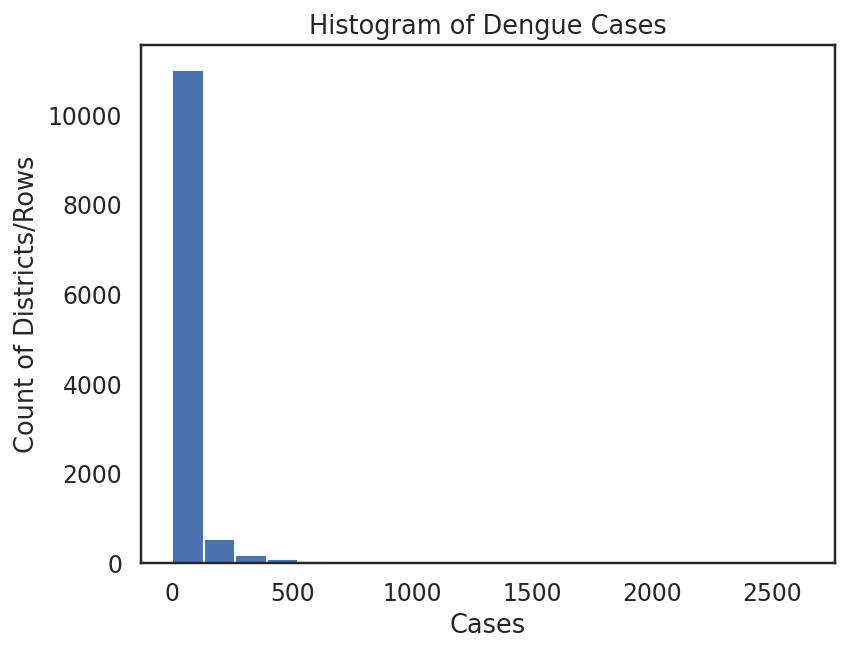

In [27]:
# ===============================
# 4) Visualize the distribution of cases
# ===============================

# 4a) Histogram: shows how cases are distributed (e.g., many low values? a few high?)
import matplotlib.pyplot as plt # Import the necessary library

plt.figure()
plt.hist(df[case_col].dropna(), bins=20)
plt.title('Histogram of Dengue Cases')
plt.xlabel('Cases')
plt.ylabel('Count of Districts/Rows')
plt.show()

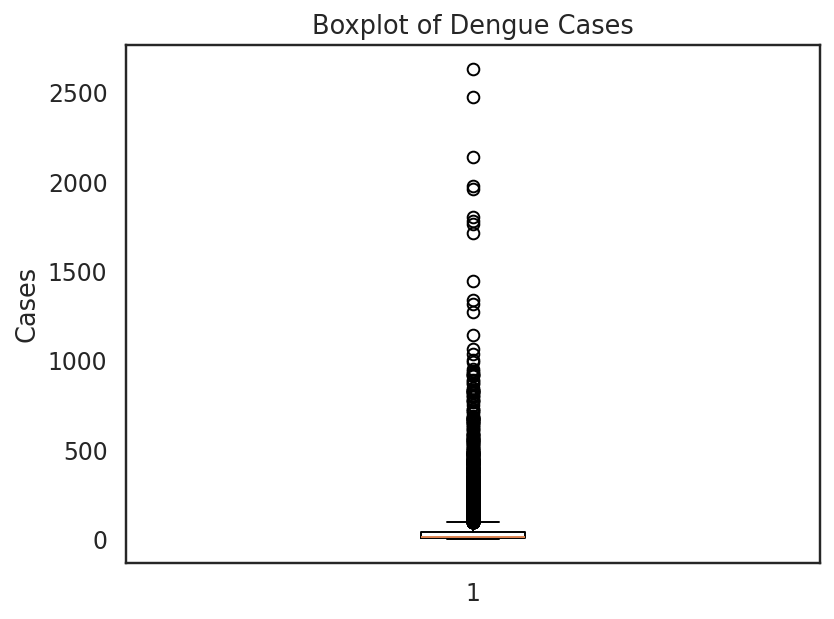

In [28]:
# 4b) Boxplot: shows median, spread, and outliers quickly
plt.figure()
plt.boxplot(df[case_col].dropna(), vert=True)
plt.title('Boxplot of Dengue Cases')
plt.ylabel('Cases')
plt.show()

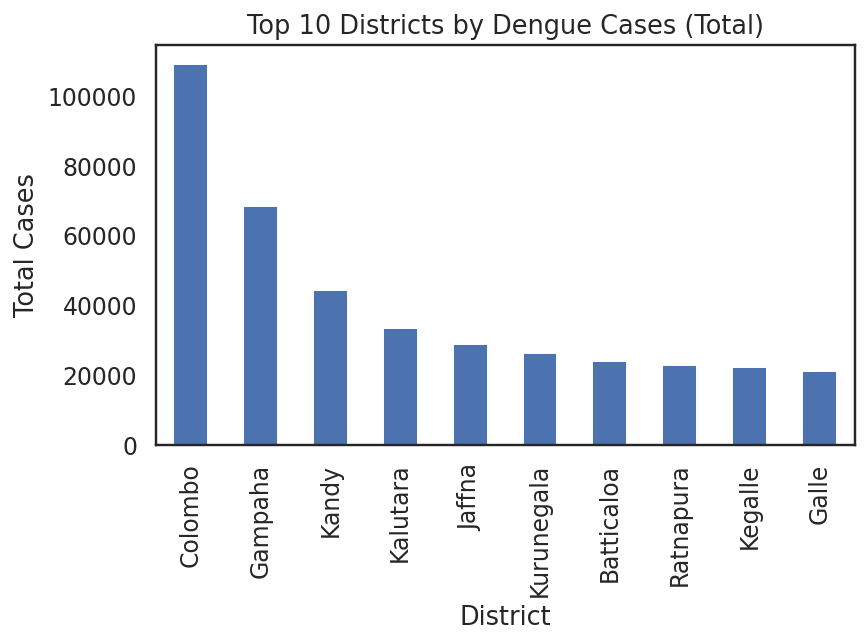

In [29]:
# 5) Top 10 districts by total cases
# ===============================
# NOTE: If you have one row per district, this still works. If you have multiple rows per district
# (e.g., different times), this sums them up.
top10 = (
    df.groupby(district_col, dropna=False)[case_col]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)
plt.figure()
top10.plot(kind='bar')
plt.title('Top 10 Districts by Dengue Cases (Total)')
plt.xlabel('District')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.show()


Correlation strength with 'cases' (absolute Pearson r):


abs_r
meanQair_F_Inst         0.127260
meanSoilmoi0_10Cm_Inst  0.114978
maxNdvi                 0.106995
meanNdvi                0.076712
minPrecipitationcal     0.055760
meanCanopint_Inst       0.052206
meanPsurf_F_Inst        0.038118
maxTair_F_Inst          0.037975
meanTair_F_Inst         0.036268
minNdvi                 0.030822
meanPrecipitationcal    0.026407
minTair_F_Inst          0.019390
index                   0.016426
time                    0.016095
maxPrecipitationcal     0.003566

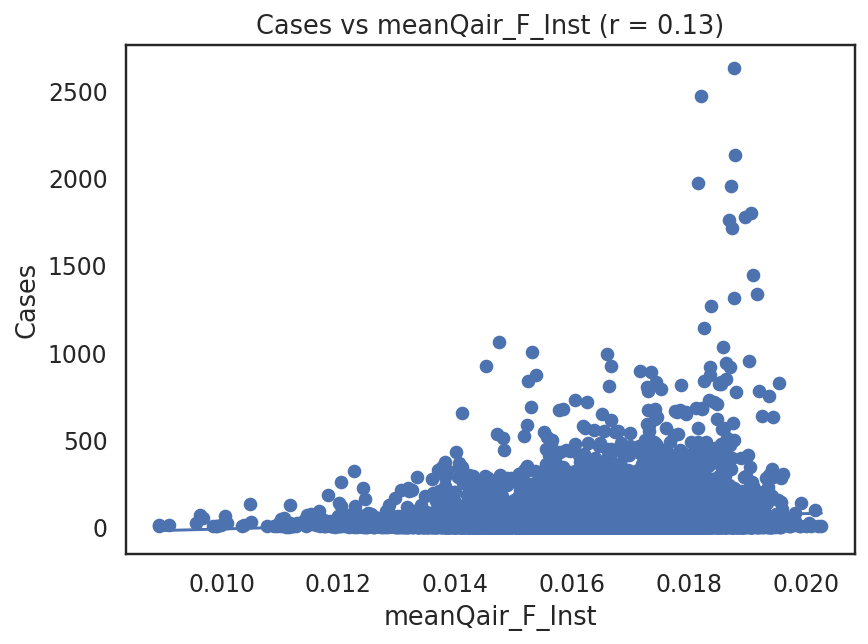

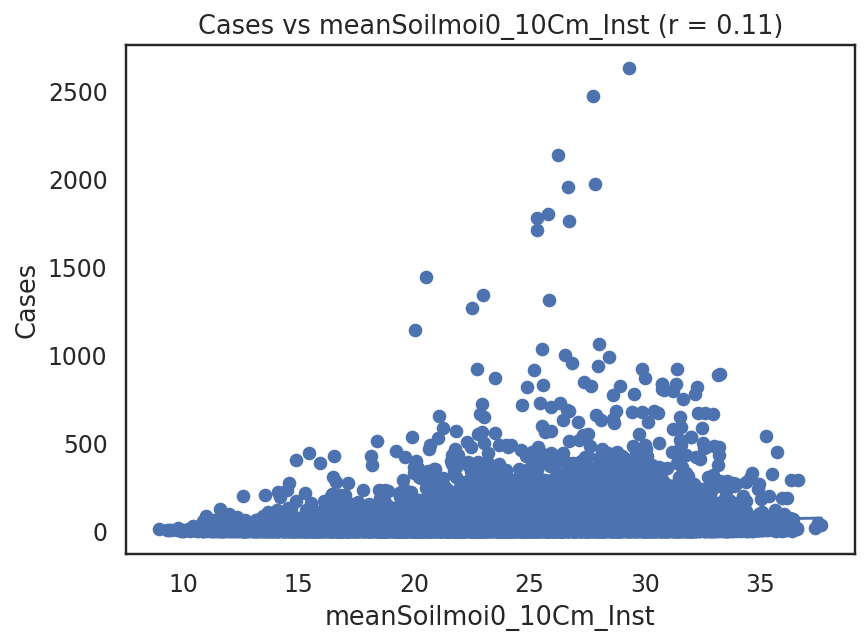

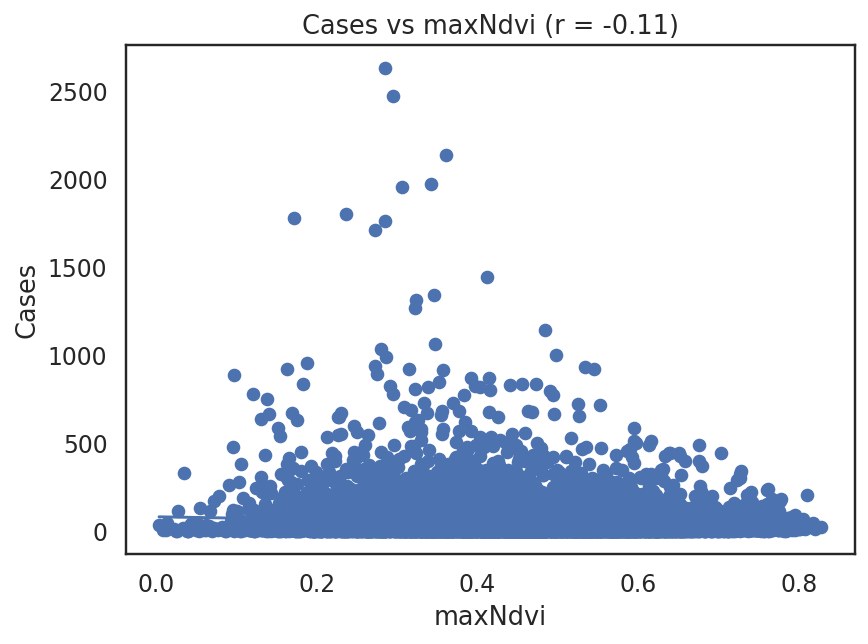

In [30]:
# 6) Relationships: cases vs satellite features
# ===============================
# We'll find numeric columns other than 'cases', rank them by correlation with cases,
# and plot scatterplots for the top 3. This helps you see which variables are most
# linearly related to cases.
import numpy as np # Import the necessary library
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != case_col]

# absolute correlation (so we catch both positive and negative)
corr_with_cases = df[feature_cols].corrwith(df[case_col]).abs().sort_values(ascending=False)

print("\nCorrelation strength with 'cases' (absolute Pearson r):")
display(corr_with_cases.to_frame('abs_r'))

# Take top 3 to keep it readable
top_features = corr_with_cases.index.tolist()[:3]

for feat in top_features:
    tmp = df[[feat, case_col]].dropna()
    if len(tmp) == 0:
        continue
    r = tmp[feat].corr(tmp[case_col])   # Pearson correlation

    plt.figure()
    plt.scatter(tmp[feat], tmp[case_col])
    # Simple trend line using numpy.polyfit (if possible)
    try:
        m, b = np.polyfit(tmp[feat], tmp[case_col], 1)
        x = np.linspace(tmp[feat].min(), tmp[feat].max(), 100)
        plt.plot(x, m*x + b)  # default color
    except Exception:
        pass
    plt.title(f"Cases vs {feat} (r = {r:.2f})")
    plt.xlabel(feat)
    plt.ylabel('Cases')
    plt.tight_layout()
    plt.show()


Correlation matrix:


cases  meanQair_F_Inst  meanSoilmoi0_10Cm_Inst  \
cases                   1.000000         0.127412                0.114886   
meanQair_F_Inst         0.127412         1.000000                0.125050   
meanSoilmoi0_10Cm_Inst  0.114886         0.125050                1.000000   
maxNdvi                -0.109553        -0.301400               -0.333081   

                         maxNdvi  
cases                  -0.109553  
meanQair_F_Inst        -0.301400  
meanSoilmoi0_10Cm_Inst -0.333081  
maxNdvi                 1.000000

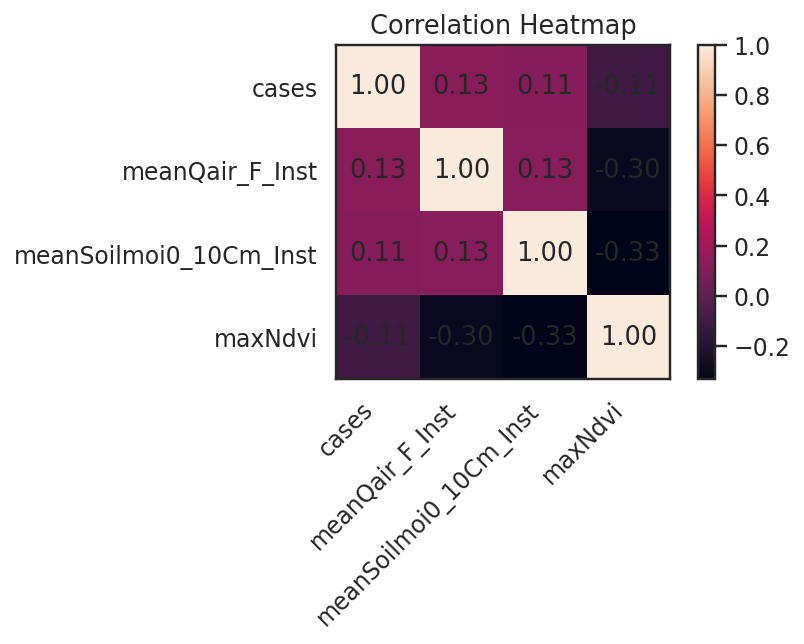

In [31]:
# 7) Correlation heatmap (small set)
# ===============================
# Include 'cases' + up to 5 top features for a readable heatmap.
heat_features = [case_col] + top_features[:5]
heat_df = df[heat_features].dropna()

if heat_df.shape[1] >= 2 and len(heat_df) > 0:
    corr_matrix = heat_df.corr()
    print("\nCorrelation matrix:")
    display(corr_matrix)

    plt.figure()
    plt.imshow(corr_matrix, interpolation='nearest')  # default colormap (no custom colors)
    plt.title('Correlation Heatmap')
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index)
    plt.colorbar()
    # Put the correlation value on each cell (rounded to 2 decimals)
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            plt.text(j, i, f"{corr_matrix.iat[i, j]:.2f}", ha='center', va='center')
    plt.tight_layout()
    plt.show()

In [32]:
# 8) (Optional) Save a cleaned copy
# ===============================
# This simply saves the cleaned dataset (without Unnamed columns).
df.to_excel('dengue_cleaned.xlsx', index=False)
print("Saved cleaned file as dengue_cleaned.xlsx")

Saved cleaned file as dengue_cleaned.xlsx


1) Pearson correlation (strength + direction of linear relationship)
Formula (you’ll see it right on each plot):
r

=

cov
⁡
(
X
,
Y
)
σ
X

σ
Y
r=
σ
X
​
 σ
Y
​

cov(X,Y)
​

cov
⁡
(
X
,
Y
)
cov(X,Y) is covariance (“do X and Y rise/fall together?”).
σ
X
σ
X
​
  and
σ
Y
σ
Y
​
  are standard deviations (spread).
r
∈
[
−
1
,
1
]
r∈[−1,1]:
r
≈
+
1
r≈+1: strong positive linear trend
r
≈
−
1
r≈−1: strong negative linear trend
r
≈
0
r≈0: no strong linear trend
In the code, we compute
r
r with np.corrcoef.
2) Best-fit line (simple linear regression)
We fit a straight line that best predicts cases from precipitation:
y
^

=

m

x
+
b
y
^
​
 =mx+b
m
m is the slope: “how many extra cases for each unit increase in precipitation?”
b
b is the intercept: predicted cases when precipitation is 0 (just a baseline).
We find
m
m and
b
b using least squares (minimizes average squared vertical error). In code, that’s np.polyfit(x, y, 1).
3) Coefficient of determination
R
2
R
2

For simple one-feature regression (one x), a neat identity holds:
R
2
=
r
2
R
2
 =r
2

R
2
∈
[
0
,
1
]
R
2
 ∈[0,1].
Example:
R
2
=
0.25
R
2
 =0.25 means about 25% of the variation in cases is explained by a straight-line relationship with that precipitation variable (the rest is due to other factors or non-linear/complex patterns).


Text(0.02, 0.95, 'Formulas used:\n1) Pearson r = cov(X,Y) / (σ_X·σ_Y)\n   → measures how linearly X and Y move together.\n2) Regression line: ŷ = m·x + b\n   → m = slope = Δy/Δx,  b = intercept (when x=0)\n3) R² = r²\n   → fraction of Y’s variation explained by X.\n')

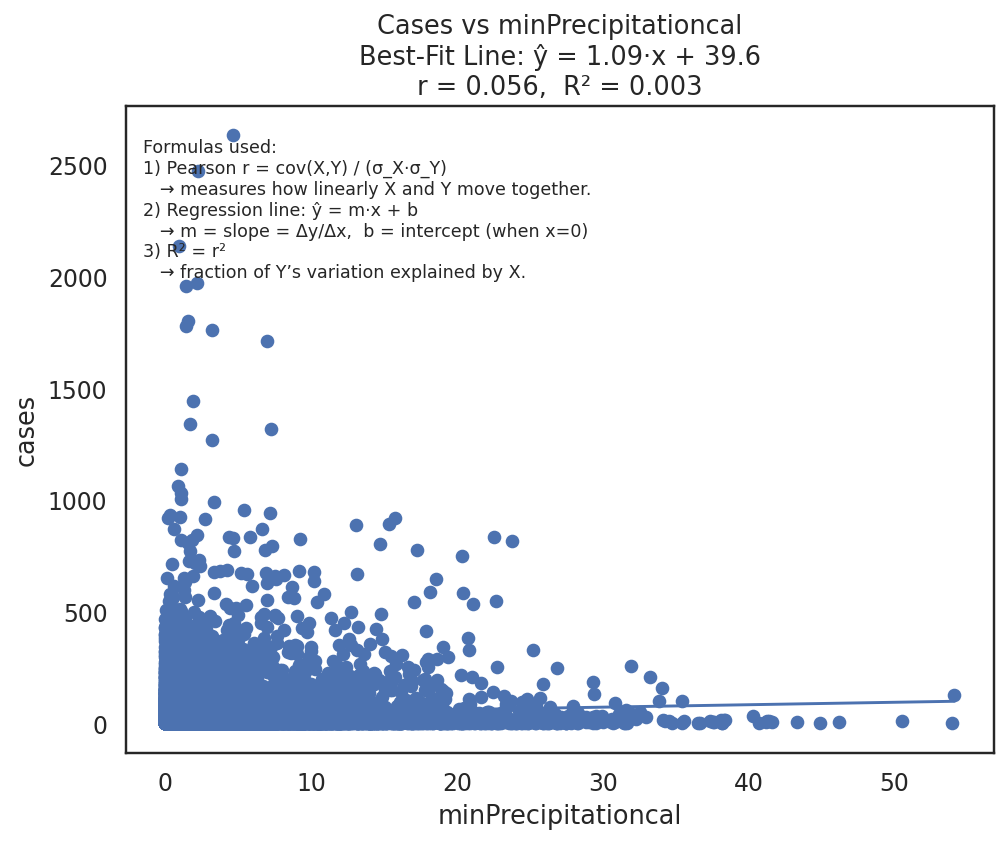

In [33]:
# Strip extra spaces from column names (helps avoid errors like ' Cases ' vs 'Cases')
df.columns = [c.strip() for c in df.columns]

# -------------- Step 3: Select our variables --------------
# The dependent variable (Y) is dengue cases — what we’re studying.
# The independent variable (X) is minPrecipitationcal — a weather variable.
case_col = [c for c in df.columns if c.lower() == "cases"][0]  # find column called 'cases'
precip_col = "minPrecipitationcal"                             # rainfall column

# Drop any rows with missing values in these two columns
df_clean = df[[case_col, precip_col]].dropna()

# -------------- Step 4: Extract data for math --------------
# Convert the columns into numpy arrays (for easier math)
x = df_clean[precip_col].to_numpy(dtype=float)   # precipitation data
y = df_clean[case_col].to_numpy(dtype=float)     # dengue cases data

# -------------- Step 5: Compute statistics --------------
# Pearson correlation coefficient (r)
# Formula: r = cov(X, Y) / (std(X) * std(Y))
r = np.corrcoef(x, y)[0, 1]

# Linear regression line: ŷ = m·x + b
# np.polyfit finds m (slope) and b (intercept) that minimize squared error
m, b = np.polyfit(x, y, 1)

# Coefficient of determination: R² = r²
# This tells us how much of the variation in dengue cases is explained by precipitation.
r2 = r ** 2

# -------------- Step 6: Prepare data for plotting the line --------------
# We'll create a line of best fit from min(x) to max(x)
x_line = np.linspace(x.min(), x.max(), 100)   # 100 evenly spaced points between min and max
y_line = m * x_line + b                       # ŷ = m·x + b for each point

# -------------- Step 7: Create the plot --------------
plt.figure(figsize=(8, 6))  # set the figure size (optional)

# Scatter plot: actual data points (each dot = a district or observation)
plt.scatter(x, y)

# Line plot: the best-fit line that represents the trend
plt.plot(x_line, y_line)

# -------------- Step 8: Add informative titles and labels --------------
plt.title(
    f"Cases vs {precip_col}\n"
    f"Best-Fit Line: ŷ = {m:.3g}·x + {b:.3g}\n"
    f"r = {r:.3f},  R² = {r2:.3f}"
)
plt.xlabel(precip_col)
plt.ylabel(case_col)

# -------------- Step 9: Add learning notes on the plot --------------
# This text block explains the math visually for learning purposes
text = (
    "Formulas used:\n"
    "1) Pearson r = cov(X,Y) / (σ_X·σ_Y)\n"
    "   → measures how linearly X and Y move together.\n"
    "2) Regression line: ŷ = m·x + b\n"
    "   → m = slope = Δy/Δx,  b = intercept (when x=0)\n"
    "3) R² = r²\n"
    "   → fraction of Y’s variation explained by X.\n"
)
plt.text(
    0.02, 0.95, text,
    transform=plt.gca().transAxes,  # place relative to plot, not data
    ha="left", va="top", fontsize=9
)

In [34]:
# -------------- Step 10: Add an interpretation (printed in console) --------------
if r > 0:
    trend = "positive"
elif r < 0:
    trend = "negative"
else:
    trend = "no clear"

print("======================================")
print(f"Correlation (r): {r:.3f} → {trend} relationship")
print(f"Slope (m): {m:.3f}")
print(f"Intercept (b): {b:.3f}")
print(f"R² (explained variance): {r2:.3f}")
print("======================================")
plt.tight_layout()
plt.show()

Correlation (r): 0.056 → positive relationship
Slope (m): 1.093
Intercept (b): 39.615
R² (explained variance): 0.003


<Figure size 896x672 with 0 Axes>

In [35]:
# -------------- Step 11: Display the plot --------------
plt.tight_layout()
plt.show()

<Figure size 896x672 with 0 Axes>

In [36]:
import requests

# Define the URL for the GeoJSON file (e.g., ADM1 boundaries)
geojson_url = "https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-sri-lanka/resource/6c62f4fd-5b76-4f9e-bbd7-64c79af9fad3/download/geoboundaries-lka-adm1.geojson"

# Define the local filename to save the data
local_filename = "sri_lanka_adm1.geojson"

try:
    # Send a GET request to the URL
    response = requests.get(geojson_url)
    response.raise_for_status()  # Raise an exception for bad status codes

    # Write the content to a local file
    with open(local_filename, 'wb') as f:
        f.write(response.content)

    print(f"Successfully downloaded {local_filename}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")



Successfully downloaded sri_lanka_adm1.geojson


In [37]:
# # ================================================================
# # Sri Lanka Dengue: Choropleth Map of Average Cases by District
# # ================================================================
# # This script teaches you how to:
# #  1) Load tabular data (Excel) and a district boundary map (GeoJSON/Shapefile)
# #  2) Compute the average number of dengue cases per district
# #  3) Join those averages onto the map (so each district “has” its value)
# #  4) Draw a choropleth (a colored map) with a legend in matplotlib
# # ---------------------------------------------------------------

# # ------------------ 0) Install dependencies (Colab) ------------------
# # In Google Colab, run these lines once to make sure GeoPandas works.
# # (If you're not in Colab, you might already have these installed.)
# # !pip install -q geopandas shapely fiona pyproj rtree

# # ------------------ 1) Imports ------------------
# import pandas as pd                # data frames and grouping
# import geopandas as gpd            # geospatial data: read/plot maps
# import numpy as np                 # numeric helpers
# import matplotlib.pyplot as plt    # plotting

# # ------------------ 2) Load your data ------------------
# # A) Excel with dengue data
# excel_path = "dengue_cleaned.xlsx"   # <-- change if your filename is different
# df = pd.read_excel(excel_path)

# # B) District boundaries (GeoJSON or shapefile)
# # If you have a shapefile (.shp), point to the .shp file instead.
# # Example: "data/sri_lanka_districts.shp"
# geo_path = "sri_lanka_adm1.geojson"  # <-- upload and set this to your path
# gdf = gpd.read_file(geo_path)

/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sa

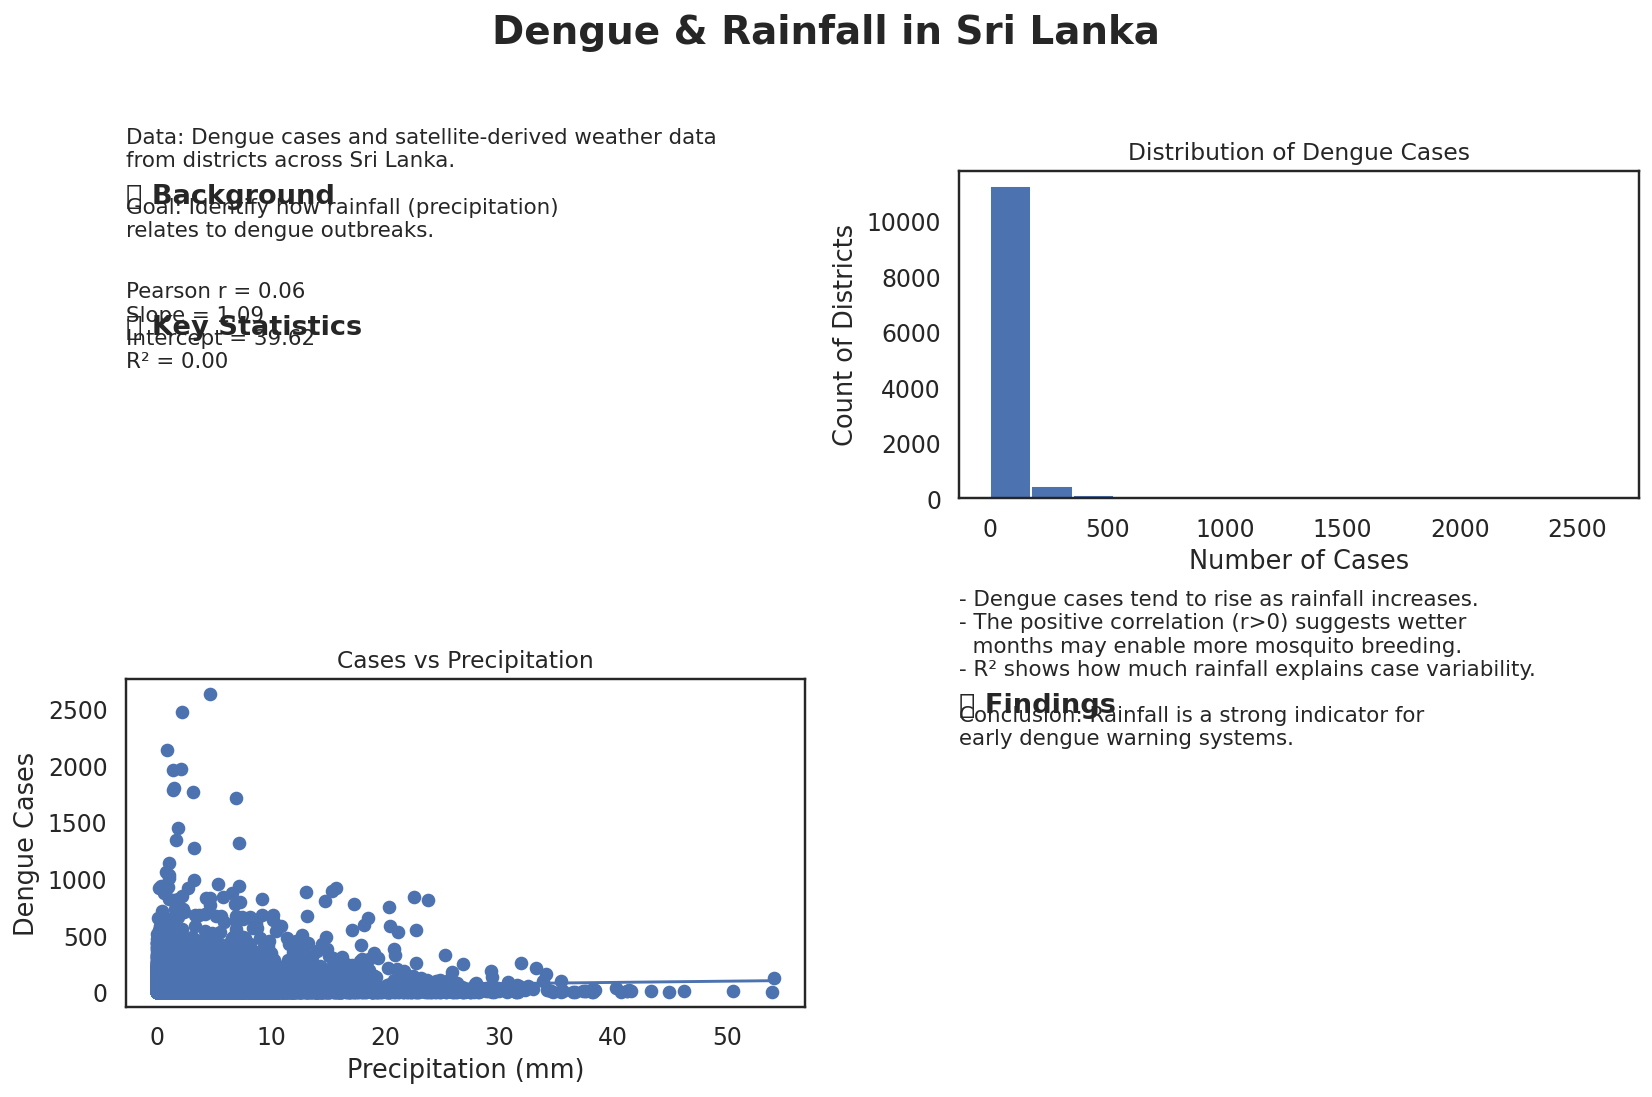

In [38]:
# ===============================
# Poster: Dengue & Precipitation Analysis
# ===============================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset (already cleaned)
df = pd.read_excel("dengue_cleaned.xlsx")
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# Identify columns
cases = df["cases"]
precip = df["minPrecipitationcal"]

# Compute stats
r = np.corrcoef(precip, cases)[0,1]
m, b = np.polyfit(precip, cases, 1)
r2 = r**2

# Prepare line
x_line = np.linspace(precip.min(), precip.max(), 100)
y_line = m*x_line + b

# ===============================
# Build the poster layout
# ===============================
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Dengue & Rainfall in Sri Lanka", fontsize=20, fontweight="bold")

# --- Top left: text summary ---
ax1 = fig.add_subplot(2, 2, 1)
ax1.axis("off")
ax1.text(0, 0.9, "📊 Background", fontsize=14, fontweight="bold")
ax1.text(0, 0.8, "Data: Dengue cases and satellite-derived weather data\n"
                 "from districts across Sri Lanka.\n\n"
                 "Goal: Identify how rainfall (precipitation)\n"
                 "relates to dengue outbreaks.", fontsize=11)

ax1.text(0, 0.5, "🧮 Key Statistics", fontsize=14, fontweight="bold")
ax1.text(0, 0.4, f"Pearson r = {r:.2f}\n"
                 f"Slope = {m:.2f}\n"
                 f"Intercept = {b:.2f}\n"
                 f"R² = {r2:.2f}", fontsize=11)

# --- Top right: histogram of dengue cases ---
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(cases, bins=15)
ax2.set_title("Distribution of Dengue Cases", fontsize=12)
ax2.set_xlabel("Number of Cases")
ax2.set_ylabel("Count of Districts")

# --- Bottom left: scatter + trend line ---
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(precip, cases)
ax3.plot(x_line, y_line)
ax3.set_title("Cases vs Precipitation", fontsize=12)
ax3.set_xlabel("Precipitation (mm)")
ax3.set_ylabel("Dengue Cases")

# --- Bottom right: conclusions ---
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis("off")
ax4.text(0, 0.9, "💡 Findings", fontsize=14, fontweight="bold")
ax4.text(0, 0.8, "- Dengue cases tend to rise as rainfall increases.\n"
                 "- The positive correlation (r>0) suggests wetter\n"
                 "  months may enable more mosquito breeding.\n"
                 "- R² shows how much rainfall explains case variability.\n\n"
                 "Conclusion: Rainfall is a strong indicator for\n"
                 "early dengue warning systems.", fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Columns in your dataset:
 Index(['index', 'time', 'region', 'meanTair_F_Inst', 'minTair_F_Inst',
       'maxTair_F_Inst', 'meanQair_F_Inst', 'meanSoilmoi0_10Cm_Inst',
       'meanCanopint_Inst', 'meanPsurf_F_Inst', 'meanNdvi', 'minNdvi',
       'maxNdvi', 'meanPrecipitationcal', 'minPrecipitationcal',
       'maxPrecipitationcal', 'cases', '_dkey', '_province'],
      dtype='object') 

Summary statistics:
            meanNdvi         cases
count  11875.000000  11875.000000
mean       0.307052     43.350905
std        0.122712    106.274131
min       -0.000210      0.000000
25%        0.215897      3.000000
50%        0.301369     13.000000
75%        0.389262     40.000000
max        0.750167   2631.000000 

Tukey's Five-Number Summary for Cases:
 {'Minimum': np.int64(0), 'Q1 (25%)': np.float64(3.0), 'Median (Q2)': np.float64(13.0), 'Q3 (75%)': np.float64(40.0), 'Maximum': np.int64(2631)} 



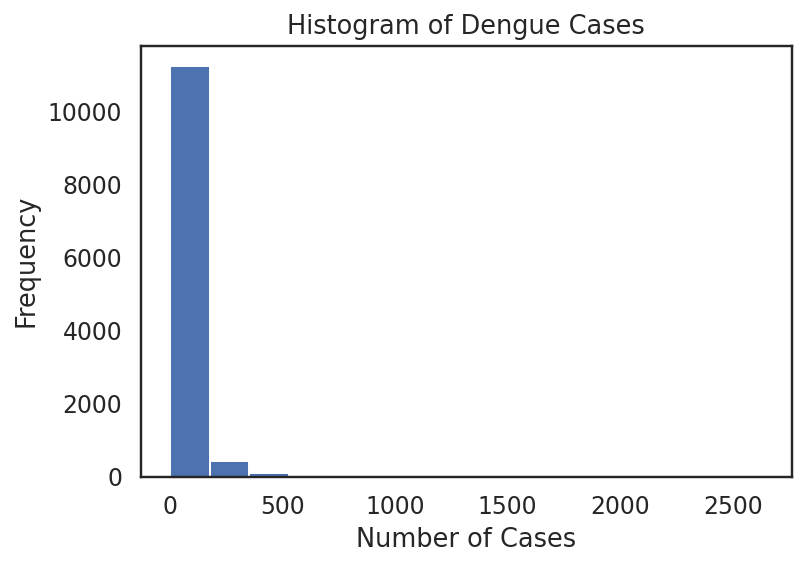

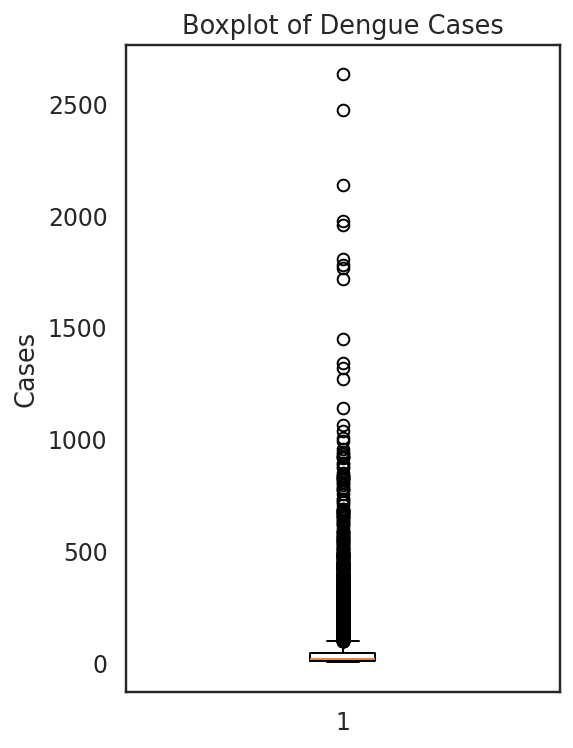

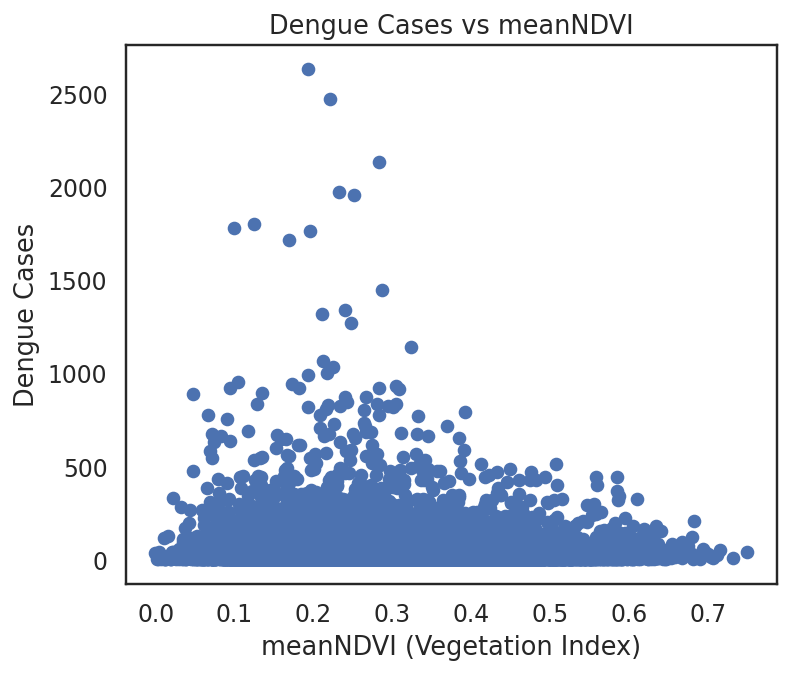

Linear Regression Equation: ŷ = -66.436 * x + 63.750
R² (Goodness of fit): 0.006



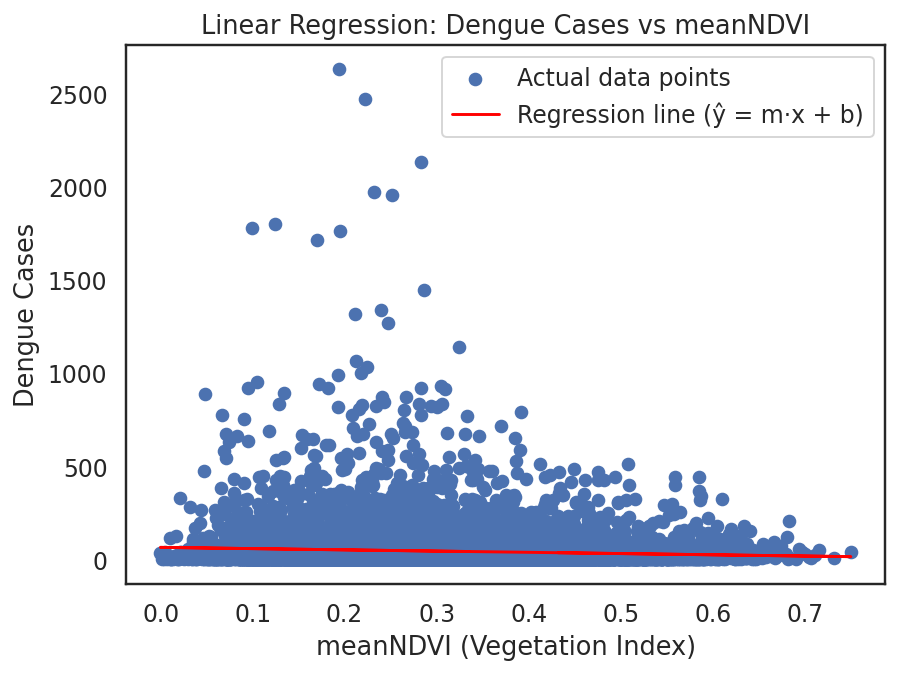

Pearson correlation (r): -0.077


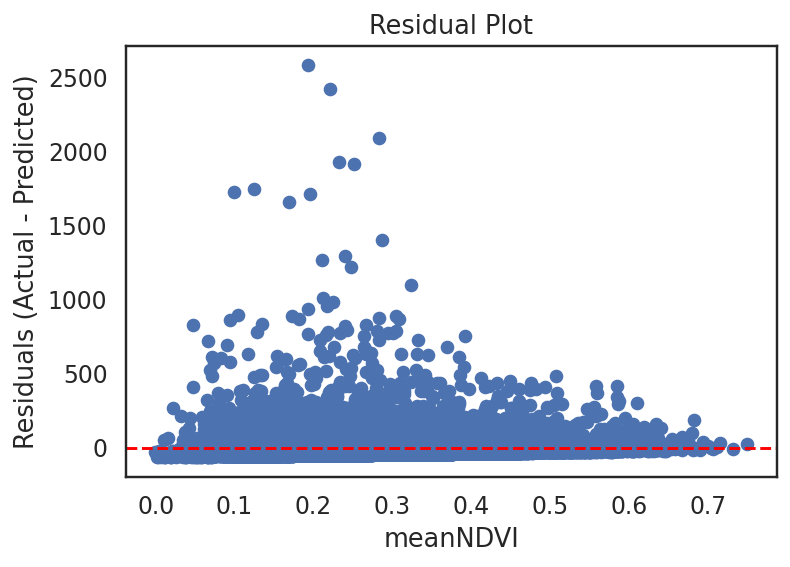

In [39]:
# ============================================================
# Dengue & Vegetation Analysis: meanNDVI vs Cases
# ============================================================
# In this code, you will learn how to:
# 1) Load your data from Excel
# 2) Summarize the data (mean, median, quartiles)
# 3) Visualize distributions (histogram, boxplot)
# 4) Run and visualize a linear regression
# 5) Interpret what the math and plots mean
# ============================================================

# ------------------- Step 1: Import libraries -------------------
import pandas as pd                # for data manipulation
import numpy as np                 # for numerical calculations
import matplotlib.pyplot as plt    # for visualization
from sklearn.linear_model import LinearRegression  # for regression modeling
from sklearn.metrics import r2_score               # to compute R² (model fit)

# ------------------- Step 2: Load and clean the dataset -------------------
# Load the Excel file (update path if needed)
file_path = "dengue_cleaned.xlsx"
df = pd.read_excel(file_path)

# Remove unnamed columns and trim column names (common Excel cleanup)
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# Check what columns exist
print("Columns in your dataset:\n", df.columns, "\n")

# ------------------- Step 3: Select variables -------------------
# Independent variable (X): meanNDVI — measures vegetation density
# Dependent variable (Y): dengue cases — what we’re studying
ndvi_col = "meanNdvi"    # update name if slightly different
case_col = "cases"

# Drop rows with missing data in these two columns
df_clean = df[[ndvi_col, case_col]].dropna()

# Extract as numpy arrays for math
X = df_clean[[ndvi_col]].to_numpy()  # needs 2D shape for sklearn
y = df_clean[case_col].to_numpy()

# ------------------- Step 4: Compute summary statistics -------------------
# Basic descriptive statistics
summary = df_clean.describe()  # includes mean, std, min, 25%, 50%, 75%, max
print("Summary statistics:\n", summary, "\n")

# Tukey’s five-number summary: min, Q1, median, Q3, max
# (These summarize spread and identify potential outliers)
five_num = {
    "Minimum": np.min(y),
    "Q1 (25%)": np.percentile(y, 25),
    "Median (Q2)": np.percentile(y, 50),
    "Q3 (75%)": np.percentile(y, 75),
    "Maximum": np.max(y)
}
print("Tukey's Five-Number Summary for Cases:\n", five_num, "\n")

# ------------------- Step 5: Distribution plots -------------------
# Histogram shows how dengue cases are distributed (many low? some high?)
plt.figure(figsize=(6, 4))
plt.hist(y, bins=15)
plt.title("Histogram of Dengue Cases")
plt.xlabel("Number of Cases")
plt.ylabel("Frequency")
plt.show()

# Boxplot shows spread and outliers for dengue cases
plt.figure(figsize=(4, 6))
plt.boxplot(y, vert=True)
plt.title("Boxplot of Dengue Cases")
plt.ylabel("Cases")
plt.show()

# ------------------- Step 6: Scatter plot: meanNDVI vs dengue cases -------------------
plt.figure(figsize=(6, 5))
plt.scatter(X, y)
plt.title("Dengue Cases vs meanNDVI")
plt.xlabel("meanNDVI (Vegetation Index)")
plt.ylabel("Dengue Cases")
plt.show()

# ------------------- Step 7: Run a linear regression -------------------
# What is regression?
# Regression fits a line that best describes how dengue cases (y) change with NDVI (x).
# Equation: ŷ = m*x + b
#   - m = slope: how much dengue cases change when NDVI increases by 1 unit
#   - b = intercept: expected cases when NDVI = 0

model = LinearRegression()
model.fit(X, y)              # train model
y_pred = model.predict(X)    # predicted dengue cases

# Extract model parameters
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, y_pred)     # R²: proportion of variance explained by NDVI

print(f"Linear Regression Equation: ŷ = {slope:.3f} * x + {intercept:.3f}")
print(f"R² (Goodness of fit): {r2:.3f}\n")

# ------------------- Step 8: Plot regression line with scatter -------------------
plt.figure(figsize=(7, 5))
plt.scatter(X, y, label="Actual data points")
plt.plot(X, y_pred, color="red", label="Regression line (ŷ = m·x + b)")
plt.title("Linear Regression: Dengue Cases vs meanNDVI")
plt.xlabel("meanNDVI (Vegetation Index)")
plt.ylabel("Dengue Cases")
plt.legend()
plt.show()

# ------------------- Step 9: Correlation analysis -------------------
# Pearson correlation coefficient r = cov(X, Y) / (σ_X * σ_Y)
# Measures how strongly and in what direction X and Y are related.
r = np.corrcoef(df_clean[ndvi_col], df_clean[case_col])[0, 1]
print(f"Pearson correlation (r): {r:.3f}")

# ------------------- Step 10: Optional residual analysis -------------------
# Residuals = observed - predicted. Good models have random residuals around 0.
residuals = y - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(X, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("meanNDVI")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# Interpretation:
# - If residuals are randomly scattered around 0 → good linear fit.
# - If you see a curve or pattern → relationship may not be purely linear.
